In [ ]:
###################### Magic commands

##%%timeit -n 1 -r 1
#%%time
import time
#start = time.time()

###################### at the end

#end = time.time()
#print(end - start)

###################### Packages

import numpy as np
import numpy.random as npr
import pandas as pd
#import Pyarrow # for pandas
import scipy.special
import math 
import numba
import matplotlib.pyplot as plt
from scipy.stats import linregress
from scipy.spatial.distance import cdist, pdist, squareform

# pip install fbm
# from fbm import FBM

###################### Options

npr.seed(0)
import warnings
warnings.filterwarnings('ignore')

#<
#>

############### Tools transfering numpy to numba

@numba.njit(parallel=True, fastmath=False) 
def np_apply_along_axis_2darray(func1d, axis, arr):
  assert arr.ndim == 2
  assert axis in [0, 1]
  if axis == 0:
    result = np.empty(arr.shape[1])
    for i in numba.prange(len(result)):
      result[i] = func1d(arr[:, i])
  else:
    result = np.empty(arr.shape[0])
    for i in numba.prange(len(result)):
      result[i] = func1d(arr[i, :])
  return result

@numba.njit(parallel=True, fastmath=False) 
def np_mean_2darray(array, axis):
  return np_apply_along_axis_2darray(np.mean, axis, array)

@numba.njit(parallel=True, fastmath=False) 
def np_std_2darray(array, axis):
  return np_apply_along_axis_2darray(np.std, axis, array)

################################################## Non-empty

def check_cond(gamma,c,tau,q):
    if 0<tau:
        if gamma<1 and 0<gamma and 2<q and 0<c and 2*(c+tau)*gamma<1 and q*(1-2*tau*gamma)>2 and q*c*gamma>1 and tau <1/(2*gamma):
            print('Valid!')
        else:
            print('Not valid!')
    else:
        if gamma<1 and 0<gamma and 2<q and 0<c and 2*(c+tau)*gamma<1 and q*c*gamma>1:
            print('Valid!')
        else:
            print('Not valid!')        
    return

def check_cond_no_q(gamma,c,tau):
    if gamma<1 and 0<gamma and 0<c and 2*(c+tau)*gamma<1:
        print('Valid!')
    else:
        print('Not valid!')   
    return

@numba.njit(parallel=True, fastmath=True)
def find_cond_all(h_gamma,h_c,h_tau,h_q,max_c,max_tau,max_q):
    gamma_mesh = np.linspace(0.01,0.99,h_gamma)
    c_mesh = np.linspace(0.1,max_c,h_c)
    tau_mesh = np.linspace(-max_tau,max_tau,h_tau)
    q_mesh = np.linspace(2.1,max_q,h_q)
    for gamma_index in numba.prange(h_gamma):
        for c_index in numba.prange(h_c): 
            for tau_index in numba.prange(h_tau):
                for q_index in numba.prange(h_q):
                    gamma=gamma_mesh[gamma_index]
                    c=c_mesh[c_index]
                    tau=tau_mesh[tau_index]
                    q=q_mesh[q_index]
                    if 0<tau:
                        if 2<q and 0<c and 2*(c+tau)*gamma<1 and q*(1-2*tau*gamma)>2 and q*c*gamma>1:
                            print([gamma, c, tau, q])
                    else:
                        if 2<q and 0<c and 2*(c+tau)*gamma<1 and q*c*gamma>1:
                            print([gamma, c, tau, q])                        
    return 'Done!'

@numba.njit(parallel=True, fastmath=False)
def find_cond_no_q(grid_gamma,max_tau):
    gamma_mesh = np.linspace(0,1,grid_gamma+1)[1:grid_gamma]
    c_mesh = np.arange(1,10)
    tau_mesh = np.arange(-max_tau,max_tau+1)
    for gamma_index in numba.prange(gamma_mesh.shape[0]):
        for c_index in numba.prange(c_mesh.shape[0]): 
            for tau_index in numba.prange(tau_mesh.shape[0]):
                gamma=gamma_mesh[gamma_index]
                c=c_mesh[c_index]
                tau=tau_mesh[tau_index]
                if 2*(c+tau)*gamma<1:
                    print([gamma, c, tau])
    return 'Done!'

@numba.njit(parallel=True, fastmath=False)
def find_gamma_no_q(grid_gamma,c,tau):
    gamma_mesh = np.linspace(0,1,grid_gamma+1)[1:grid_gamma]
    for gamma_index in numba.prange(gamma_mesh.shape[0]):
        gamma=gamma_mesh[gamma_index]
        if 2*(c+tau)*gamma<1:
            print([gamma, c, tau])
    return 'Done!'

@numba.njit(parallel=True, fastmath=False)
def find_cond_c_no_q(c,grid_gamma,max_tau):
    gamma_mesh = np.linspace(0,1,grid_gamma+1)[1:grid_gamma]
    tau_mesh = np.arange(-max_tau,max_tau+1)
    for gamma_index in numba.prange(gamma_mesh.shape[0]):
        for tau_index in numba.prange(tau_mesh.shape[0]):
            gamma=gamma_mesh[gamma_index]
            tau=tau_mesh[tau_index]
            if 2*(c+tau)*gamma<1:
                print([gamma, c, tau])
    return 'Done!'

@numba.njit(parallel=True, fastmath=False)
def find_cond_c_tau_no_q(c,tau,grid_gamma):
    gamma_mesh = np.linspace(0,1,grid_gamma+1)[1:grid_gamma]
    tau_mesh = np.arange(-max_tau,max_tau+1)
    for gamma_index in numba.prange(gamma_mesh.shape[0]):
        for tau_index in numba.prange(tau_mesh.shape[0]):
            gamma=gamma_mesh[gamma_index]
            tau=tau_mesh[tau_index]
            if 2*(c+tau)*gamma<1:
                print([gamma, c, tau])
    return 'Done!'

################################################## Generating Data

@numba.njit(parallel=False, fastmath=False)
def Lomax_quantile_function(x,theta,s):  
    return s*((1-x)**(-1/theta)-1)

@numba.njit(parallel=True, fastmath=False)
def Pareto_quantile_function(x,gamma,s): # support is  {x \ge s} and theta=1/\gamma
    return s*(1-x)**(-gamma)

#The Burr distribution has survival distribution $\bar{F}(y)=(1+y^\rho)^{-\theta} \in 2\RV_{-\theta \rho,-\rho}$ where $x\ge 0$ and $\theta,\rho>0$.
@numba.njit(parallel=True, fastmath=False) # rho,theta positive
def Burr_quantile_function(x,theta,rho): 
    return ((1-x)**(-1/theta)-1)**(1/rho)

@numba.njit(parallel=True, fastmath=False)
def beta_func3(d):
    grid=np.linspace(0,1,d)
    norm=np.sqrt(np.sum(np.exp(-grid**2+grid)**2)/d)
    return np.exp(-grid**2+grid)/norm

@numba.njit(parallel=True, fastmath=False)
def beta_func2(d):
    grid=np.linspace(0,1,d)
    norm=np.sqrt(np.sum(np.exp(-grid)**2)/d)
    return np.exp(-grid)/norm

@numba.njit(parallel=True, fastmath=False)
def beta_func(d):
    grid=np.linspace(0,1,d)
    norm=np.sqrt(np.sum(np.sin(2*np.pi*grid)**2)/d)
    return np.sin(2*np.pi*grid)/norm

@numba.njit(parallel=True, fastmath=False)
def beta_func5(d):
    grid=np.linspace(0,1,d)
    norm=np.sqrt(np.sum(np.sin(1/(1/12+grid**2))/d))
    return np.sin(1/(1/12+grid**2))/norm

@numba.njit(parallel=True, fastmath=False)
def beta_func6(d):
    grid=np.linspace(0,1,d)
    norm=np.sqrt(np.sum(np.cos(2*np.pi*grid+np.sin(1/(grid+1/10)))/d))
    return np.cos(2*np.pi*grid+np.sin(1/(grid+1/10)))/norm

@numba.njit(parallel=True, fastmath=False)
def beta_func7(d):
    grid=np.linspace(0,1,d)
    norm=np.sqrt(np.sum(np.cos(2*np.pi*grid)**2)/d)
    return np.cos(2*np.pi*grid)/norm


@numba.njit(parallel=True, fastmath=False)
def beta_func4(d):
    grid=np.linspace(0,1,d)
    norm=np.sqrt(np.sum(np.sin(2*np.pi*grid)**2)/d)
    return np.sin(2*np.pi*grid)/norm

@numba.njit(parallel=True, fastmath=False)
def coeurjolly_cholesky_fbm_1D(d,H,sigma):
    H2 = 2 * H
    matcov = np.zeros((d-1,d-1))
    for i in numba.prange(d-1):
        for j in numba.prange(i,d-1):
            r = (sigma**2)*(1/2)*(abs(i+1)**H2 + abs(j+1)**H2 - abs(j - i)**H2)
            r = r/(d**H2)
            matcov[i, j] = r
            matcov[j, i] = matcov[i, j]
    L = np.linalg.cholesky(matcov)
    Z = npr.normal(0,1,size=(d - 1))
    fBm = np.dot(L , Z)
    #out=np.concatenate(([0], fBm))
    # out=np.hstack(([0], fBm))
    out= np.asarray([0] + list(fBm))
    return out

# @Article{RePEc:jss:jstsof:v:005:i07,
#  author={Coeurjolly, Jean-Francois},
#  title={{Simulation and identification of the fractional Brownian motion: a bibliographical and comparative study}},
#  journal={Journal of Statistical Software},
#  year=2000,
#  volume={5},
#  number={i07},
#  pages={},
#  month={},
#  keywords={},
#  doi={http://hdl.handle.net/10.18637/jss.v005.i07}
#}

@numba.njit(parallel=True, fastmath=False)
def coeurjolly_cholesky_fbm_array(Z,H,sigma): # Z=npr.normal(0,1,size=(N,n,d - 1))
    N=Z.shape[0]
    n=Z.shape[1]
    d=Z.shape[2]+1
    out = np.zeros((N,n,d))
    for p in numba.prange(N):
        for q in numba.prange(n):    
            H2 = 2 * H
            matcov = np.zeros((d-1,d-1))
            for i in numba.prange(d-1):
                for j in numba.prange(i,d-1):
                    r = (sigma**2)*(1/2)*(abs(i+1)**H2 + abs(j+1)**H2 - abs(j - i)**H2)
                    r = r/(d**H2)
                    matcov[i, j] = r
                    matcov[j, i] = matcov[i, j]
            L = np.linalg.cholesky(matcov)
            fBm = np.dot(L , Z[p,q,:])
            #out=np.concatenate(([0], fBm))
            # out=np.hstack(([0], fBm))
            out[p,q,:]= np.asarray([0] + list(fBm))
    return out

@numba.njit(parallel=True, fastmath=False)
def sigma(u,c,snr): 
    return (u**c)/snr

@numba.njit(parallel=True, fastmath=False)
def noise_mean(d,mu):
    grid=np.linspace(0,1,d)
    return mu*grid

@numba.njit(parallel=True, fastmath=False)
def coeurjolly_cholesky_fbm_var(Y,Z,H,c,snr,mu): #Z = npr.normal(0,1,size=(N,n,d - 1))  
                                     #Y = Pareto_iterated_sample(N,n,theta,s)
    N=Y.shape[0]
    n=Y.shape[1]
    d=Z.shape[2]+1
    out = np.zeros((N,n,d))
    H2 = 2 * H
    matcov = np.zeros((d-1,d-1))
    for p in numba.prange(N):
        for q in numba.prange(n):
            matcov = np.zeros((d-1,d-1))
            for i in numba.prange(d-1):
                for j in numba.prange(i,d-1):
                    r = (sigma(Y[p,q],c,snr)**2)*(1/2)*(abs(i+1)**H2 + abs(j+1)**H2 - abs(j - i)**H2)
                    r = r/(d**H2)
                    matcov[i, j] = r
                    matcov[j, i] = matcov[i, j]
            L = np.linalg.cholesky(matcov)
            fBm = np.dot(L , Z[p,q,:])
            out[p,q,:]= np.asarray([0]+list(fBm)) + noise_mean(d,mu)
    return out

################################################## Estimation
    
@numba.njit(parallel=True, fastmath=False)
def threshold_index(X,Y,Y_sort_index,tau,m,start): # 0\le start \le n-1
    N=X.shape[0]
    n=X.shape[1]
    out=np.zeros((N,))
    aux=concomittant_corr(X,Y,Y_sort_index,tau,m)[:,start:]
    return start+np.argmax(aux,axis=1)
    
@numba.njit(parallel=True, fastmath=False)
def threshold(X,Y,Y_sort_index,tau,m,start): # 0\le start \le n-1
    N=X.shape[0]
    n=X.shape[1]
    y_matrix_out = np.zeros((N,n))
    YY=np.copy(Y)
    Y_sort=sort_2d_array(YY)
    index = threshold_index(X,Y,Y_sort_index,tau,m,start)
    for i in numba.prange(N):
        y_matrix_out[i,:] = Y_sort[i,n-index[i]-1]*np.ones((n,))
    return y_matrix_out

@numba.njit(parallel=True, fastmath=False) 
def fepls_weight(Y,y_matrix,nu): # Y of size (N,n)
                             # y_matrix of shape (N,n), for instance y_matrix = y*np.ones((N,n)) where y threshold
                             # nu is such that \psi(x) = x^nu
    N=Y.shape[0]
    n=Y.shape[1]
    out=np.zeros((N,))
    aux = Y**nu # size (N,n) - \psi(Y_i)
    aux2 = np.multiply(aux,np.greater_equal(Y,y_matrix)) # size (N,n) - Product \psi(Y_i)*1_{Y_i \ge y}
    return np.sum(aux2,axis=1)/n # size (N,)

#@numba.njit(parallel=True, fastmath=False) # It seems that "greater_equal" and numba don't work well together
def fepls(X,Y,y_matrix,tau): # X of size (N,n,d) and Y of size (N,n)
                             # y_matrix of shape (N,n), for instance y_matrix = y*np.ones((N,n)) where y threshold
                             # tau is the tail index of \vfi
    N=X.shape[0]
    n=X.shape[1]
    d=X.shape[2]
    out=np.zeros((N,d))
    for j in range(d):
        aux = np.multiply(X[:,:,j],Y**tau) # size (N,n,d) - Product \vfi(Y_i)*X_i
        out2 = np.multiply(aux,np.greater_equal(Y,y_matrix)) # size (N,n) - Product \vfi(Y_i)*X_i*1_{Y_i \ge y}
        out[:,j]= np.sum(out2,axis=1)/n # (N,d)
    norms=np.sqrt(np.sum(out**2,axis=1)/d) # length (N,)
    out2 =  out * (norms.reshape((norms.size, 1)))**(-1)
    return out2 # size (N,d)

@numba.njit(parallel=True, fastmath=False) 
def fepls_numba(X,Y,y_matrix,tau): # X of size (N,n,d) and Y of size (N,n)
                             # y_matrix of shape (N,n), for instance y_matrix = y*np.ones((N,n)) where y threshold
                             # tau is the tail index of \vfi
    N=X.shape[0]
    n=X.shape[1]
    d=X.shape[2]
    out=np.zeros((N,d))
    for j in numba.prange(d):
        aux = np.multiply(X[:,:,j],Y**tau) # size (N,n,d) - Product \vfi(Y_i)*X_i
        out2 = np.multiply(aux,np.greater_equal(Y,y_matrix)) # size (N,n) - Product \vfi(Y_i)*X_i*1_{Y_i \ge y}
        out[:,j]= np.sum(out2,axis=1)/n # (N,d)
    norms=np.sqrt(np.sum(out**2,axis=1)/d) # length (N,)
    out2 =  out * (norms.reshape((norms.size, 1)))**(-1)
    return out2 # size (N,d)

# g(t)= t^c with c \in \{1/4,1/2,1,3/2\} 
# X = g(Y)\beta + \eps

@numba.njit(parallel=True, fastmath=False) 
def Hill(Y,int_seq): # Y of size (N,n), y number, int_seq is an intermediate sequence, ie such that int_seq << n
    N=Y.shape[0]
    n=Y.shape[1]
    Y_ord=np.copy(Y)
    Y_ord=np.sort(Y_ord) 
    Y_2=Y_ord[:,n-int_seq-1]
    aux=Y_ord/Y_2[:, None]
    out=np.log(aux[:,0:n-int_seq])
    return (1/int_seq)*np.sum(out,axis=1) # size (N,)

#### Same as np.sort for 2D arrays but works with numba njit+parallel
@numba.njit(parallel=True, fastmath=False) 
def sort_2d_array(x):
    n,m=np.shape(x)
    for row in numba.prange(n):
        x[row]=np.sort(x[row])
    return x

@numba.njit(parallel=True, fastmath=False) 
def hatbeta_dot_beta(X,Y,tau,l):
    N=X.shape[0]
    n=X.shape[1]
    d=X.shape[2]    
    y_array=np.zeros((N,n,np.arange(int(n/l)).size))
    out=np.zeros((N,np.arange(int(n/l)).size))
    YY=np.copy(Y)
    for p in numba.prange(int(n/l)):
        y_array[:,0,p]=sort_2d_array(YY)[:,n-l*p-1]
        for k in numba.prange(N):
            y_array[k,:,p]=y_array[k,0,p]
        hat_beta=fepls_numba(X,Y,y_array[:,:,p],tau) 
        out[:,p]=(1/d)*np.sum(np.multiply(hat_beta,X[:,p,:]),axis=1) 
    return out

@numba.njit(parallel=True, fastmath=False) 
def concomittant_corr(X,Y,Y_sort_index,tau,m): # 1\le m \le n # Y_sort_index = np.argsort(Y,axis=1)
    N = X.shape[0]
    n = X.shape[1]
    d = X.shape[2]
    out = np.zeros((N,m))
    YY=np.copy(Y)
    Y_sort=sort_2d_array(YY)
    for k in numba.prange(m):
        y_array = np.zeros((N,n,k+1))
        aux = np.zeros((N,k+1))
        aux2 = np.zeros((N,k+1))
        aux3 = Y_sort[:,n-k-1:] # shape (N,k+1)
        aux3_sum = np.sum(aux3,axis=1)
        for i in numba.prange(k):
            y_array[:,0,i] = Y_sort[:,n-i-1]
            for j_2 in numba.prange(N):
                y_array[j_2,:,i] = y_array[j_2,0,i]
            hat_beta = fepls_numba(X,Y,y_array[:,:,i],tau) 
            for j_1 in numba.prange(N):
                i_c = Y_sort_index[j_1,i]
                aux[j_1,i]=(1/d)*np.sum(np.multiply(hat_beta[j_1,:],X[j_1,i_c,:]))
                aux2[j_1,i]= np.multiply(aux[j_1,i],Y_sort[j_1,n-i-1]) 
                out[j_1,k]= np.corrcoef(aux3[j_1,:],aux[j_1,:])[0,1]
    return out
    
def bitcoin_concomittant_corr(X,Y,tau,m): # 1\le m \le n 
    N = X.shape[0]
    n = X.shape[1]
    d = X.shape[2]
    out = np.zeros((m))
    Y_sort=np.sort(Y,axis=1)
    Y_sort_index = np.argsort(Y,axis=1)
    for k in range(m):
        y_array = np.zeros((N,n,k+1))
        aux = np.zeros((k+1))
        aux2 = np.zeros((k+1))
        aux3 = Y_sort[0,n-k-1:] # shape (k+1)
        aux3_sum = np.sum(aux3)
        for i in range(k):
            y_array[:,:,i] = (Y_sort[0,n-i-1])*np.ones((1,n))
            hat_beta = fepls(X,Y,y_array[:,:,i],tau) 
            i_c = Y_sort_index[0,i]
            aux[i]=(1/d)*np.sum(np.multiply(hat_beta[0,:],X[0,i_c,:]))
            aux2[i]= np.multiply(aux[i],Y_sort[0,n-i-1]) 
            out[k]= np.corrcoef(aux3,aux)[0,1]
    return np.abs(out)

def bitcoin_threshold_index(X,Y,tau,m,start): # 0\le start \le n-1; m = int(n/5) where n=X.shape[1]
    N=X.shape[0]
    n=X.shape[1]
    out = np.zeros((N,n))
    return start+np.argmax(bitcoin_concomittant_corr(X,Y,tau,m)[start:])
    
@numba.njit(parallel=True, fastmath=False) 
def hatbeta_dot_X(X,hat_beta): # hat_beta=fepls(X,Y,y_matrix,tau) of shape (N,d)
    N=X.shape[0]
    n=X.shape[1]
    d=X.shape[2]    
    out=np.zeros((N,n))
    for i in numba.prange(n):
            out[:,i]=(1/d)*np.sum(np.multiply(hat_beta,X[:,i,:]),axis=1) 
    return out

@numba.njit(parallel=True, fastmath=False) # the same as np.dot(X,beta_func(d))/d (which is preferable)
def beta_dot_X(X):
    N=X.shape[0]
    n=X.shape[1]
    d=X.shape[2]    
    out=np.zeros((N,n))
    for i in numba.prange(n):
            out[:,i]=(1/d)*np.sum(np.multiply(X[:,i,:],beta_func(d)),axis=1) 
    return out
    
@numba.njit(parallel=True, fastmath=False) # np.dot(X,beta_func(d))/d
def beta_dot_X(X,beta_param):
    N=X.shape[0]
    n=X.shape[1]
    d=X.shape[2]    
    out=np.zeros((N,n))
    for i in numba.prange(n):
        if beta_param == 1:
            out[:,i]=(1/d)*np.sum(np.multiply(X[:,i,:],beta_func(d)),axis=1)
        elif beta_param == 2:
            out[:,i]=(1/d)*np.sum(np.multiply(X[:,i,:],beta_func2(d)),axis=1)
        elif beta_param == 3:
            out[:,i]=(1/d)*np.sum(np.multiply(X[:,i,:],beta_func3(d)),axis=1)
        elif beta_param == 4:
            out[:,i]=(1/d)*np.sum(np.multiply(X[:,i,:],beta_func4(d)),axis=1)
    return out
    
@numba.njit(parallel=True, fastmath=False) 
def conditional_cov_Y_hat_beta_X(X,Y,hat_beta,y_matrix,tau): #hat_beta = fepls(X,Y,y_matrix,tau)
    N=X.shape[0]
    n=X.shape[1]
    d=X.shape[2]    
    A=hatbeta_dot_X(X,hat_beta)
    cov_A=np.zeros((N,))
    cov_B=np.zeros((N,))
    for k in numba.prange(N):
        cov_A[k] = (((A[k,:])[Y[k,:]>y_matrix[k,:]])*((Y[k,:])[Y[k,:]>y_matrix[k,:]])).mean() - ((A[k,:])[Y[k,:]>y_matrix[k,:]]).mean()*((Y[k,:])[Y[k,:]>y_matrix[k,:]]).mean()
    return cov_A

#@numba.njit(parallel=True, fastmath=False) # does not work with numba (no idea why)
def conditional_cov_Y_beta_X(X,Y,y):
    N=X.shape[0]
    n=X.shape[1]
    d=X.shape[2]    
    B=beta_dot_X(X)
    cov_B=np.zeros((N,))
    for k in numba.prange(N):
        cov_B[k] = (((B[k,:])[Y[k,:]>y])*((Y[k,:])[Y[k,:]>y])).mean()-((B[k,:])[Y[k,:]>y]).mean()*((Y[k,:])[Y[k,:]>y]).mean()
    return cov_B

def Exponential_QQ_Plot_1D(Y,k):
    n=Y.shape[1]
    out=np.zeros((k))
    out2=np.zeros((k))
    YY=np.sort(Y,axis=1)
    for i in range(k):
        out[i]=np.log((k+1)/(i+1))
        out2[i]=  np.log(YY[0,n-i-1])-np.log(YY[0,-k])
    return np.column_stack((out,out2))

################################################## Conditional quantile estimation (2D+3D array)
################# Application: Bitcoin/SP500 quantile

@numba.njit(parallel=True, fastmath=False) 
def Epanechnikov_kernel_2D(x): # x is a np.array of shape (p,q);     W=np.where(np.abs(x)<=1,1,0)
    out = np.zeros_like(x)
    x=np.asarray(x)
    for i in numba.prange(x.shape[0]):
        for j in numba.prange(x.shape[1]):
            if x[i,j]<=1 and x[i,j]>=0:
                out[i,j] = np.multiply(3/2,1-np.power(x[i,j],2))
            else:
                out[i,j]=0
    return out

@numba.njit(parallel=True, fastmath=False) 
def Epanechnikov_kernel_1D(x): # x is a np.array of shape (p);     W=np.where(np.abs(x)<=1,1,0)
    out = np.zeros_like(x)
    x=np.asarray(x)
    for i in numba.prange(x.shape[0]):
        if x[i]<=1 and x[i]>=0:
            out[i] = np.multiply(3/2,1-np.power(x[i],2))
        else:
            out[i]=0
    return out
    
@numba.njit(parallel=False, fastmath=False) 
def Gaussian_kernel(x):
    return (1/np.sqrt(2*np.pi))*np.exp(-0.5*np.power(x,2))

@numba.njit(parallel=True, fastmath=False) 
def univariate_Nadaraya_weight_2D(X_2D,dimred,x_func,x,h,type,kernel): # X_2D of shape (n,d), Y of shape (n), x_func of shape (d,)
    # dimred of shape (d,) is e.g. beta_func(d) or (fepls(X,Y,y_matrix,tau))[0,:]
    # Y|(X,dimred)=(x_func,dimred) (type 1) vs Y|(X,dimred) = x (type 2)
    d=x_func.shape[0]
    if type == 1:
        if kernel == 1:
            K_h=Epanechnikov_kernel_1D((np.dot(X_2D,dimred)/d-np.dot(x_func,dimred)/d)/h) # shape (n,)
        if kernel == 2:
            K_h=Gaussian_kernel((np.dot(X_2D,dimred)/d-np.dot(x_func,dimred)/d)/h) # shape (n,)
    if type == 2:     
        if kernel == 1:
            K_h=Epanechnikov_kernel_1D((np.dot(X_2D,dimred)/d-x)/h) # shape (n,)
        if kernel == 2:
            K_h=Gaussian_kernel((np.dot(X_2D,dimred)/d-x)/h) # shape (n,)
    return K_h/np.sum(K_h) ### shape = (,n)

@numba.njit(parallel=True, fastmath=False) 
def functional_Nadaraya_weight_2D(X_2D,x_func,h,kernel): # X.shape = (n,d); h is positive ; x_func \in H ie of shape (d,)
    d=x_func.shape[0]
    aux = (X_2D-x_func*np.ones(d))**2 # shape = (n,d)
    norm = np.sqrt((1/d)*np.sum(aux,axis=1)) # shape = (n,)
    if kernel == 1:
        K_h= Epanechnikov_kernel_1D(norm/h) # shape = (n,)
    if kernel == 2:
        K_h= Gaussian_kernel(norm/h)## shape = (n,)
    return K_h/np.sum(K_h) ### shape = (n,)

######### Not used 
@numba.njit(parallel=True, fastmath=False) 
def univariate_Nadaraya_weight_3D(X,dimred_2D,x_func,x,h,type,kernel): # X of shape (N,n,d), Y of shape (N,n), dimred_2D of shape (N,d)
    # x_func of shape (d,) is e.g. beta_func(d) or (fepls(X,Y,y_matrix,tau))[0,:]
    # x is a real number (e.g., x=x_grid[p] for p \leq m)
    # Y|(X,dimred)=(x_func,dimred) (type 1) vs Y|(X,dimred) = x (type 2)
    N=X.shape[0]
    n=X.shape[1]
    d=X.shape[2]
    K_h = np.zeros((N,n))
    for i in numba.prange(N):
        if type == 1:
            if kernel == 1:
                K_h[i,:]=Epanechnikov_kernel_1D((np.dot(X[i,:,:],dimred_2D[i,:])/d-np.dot(x_func,dimred_2D[i,:])/d)/h) # shape (n,)
            if kernel == 2:
                K_h[i,:]=Gaussian_kernel((np.dot(X[i,:,:],dimred_2D[i,:])/d-np.dot(x_func,dimred_2D[i,:])/d)/h) # shape (n,)
        if type == 2:
            if kernel == 1:
                K_h[i,:]=Epanechnikov_kernel_1D((np.dot(X[i,:,:],dimred_2D[i,:])/d-x)/h) # shape (n,)   
            if kernel == 2:
                K_h[i,:]=Gaussian_kernel((np.dot(X[i,:,:],dimred_2D[i,:])/d-x)/h) # shape (n,)
    return np.transpose(np.transpose(K_h)/np.sum(K_h,axis=1)) ### shape = (N,n)

######### Not used
@numba.njit(parallel=True, fastmath=False) 
def functional_Nadaraya_weight_3D(X,x_func,h_func_2D,kernel): # X.shape = (N,n,d); h_func_2D.shape = (N,n); x_func \in H ie of shape (d,)
    N=X.shape[0]
    n=X.shape[1]
    d=X.shape[2]
    aux = np.zeros((N,n,d))
    for i in numba.prange(N):
        aux[i,:,:] = (X[i,:,:]-x_func*np.ones(d))**2
    norm = np.sqrt((1/d)*np.sum(aux,axis=2))
    if kernel == 1:
        K_h= Epanechnikov_kernel_2D(norm/h_func_2D)
    if kernel == 2:
        K_h= Gaussian_kernel(norm/h_func_2D)      
    return np.transpose(np.transpose(K_h)/np.sum(K_h,axis=1)) ### shape = (N,n)
#########

@numba.njit(parallel=True, fastmath=False)   
def weighted_quantile(data,weight,alpha):  # data.shape=weight.shape=(n,) 
    # alpha is the treshold in (0,1)
    sorter = np.argsort(data)
    data = data[sorter]
    weight = weight[sorter]
    weighted_quantiles = np.cumsum(weight) - 0.5 * weight
    weighted_quantiles /= np.sum(weight)
    return np.interp(alpha, weighted_quantiles, data)

@numba.njit(parallel=True, fastmath=False) 
def iterated_weq_2D(data_2D,weight,alpha): # same treshold for all marginals and iterations 
    # data.shape = (N,n); weight.shape=(N,n)
    N=data_2D.shape[0]
    n=data_2D.shape[1]
    out = np.zeros((N,))
    for k in numba.prange(N):
        out[k]=weighted_quantile(data_2D[k,:],weight[k,:],alpha)
    return out # shape = (N)

################################################## ][ Tail index  

@numba.njit(parallel=True, fastmath=False)
def get_hill_estimator(ordered_data):
    """
    Function to calculate Hill estimator array given an ordered data
    sequence. Decreasing ordering is required; e.g. ordered_data = np.sort(data[0,:])[::-1] where data might be Y (of shape (N,n))
    :param ordered_data: numpy array of ordered data for which the 1st moment (Hill estimator) is calculated.
    :return: numpy array of Hill estimator corresponding to all possible order statistics of the dataset.
    """
    logs = np.log(ordered_data)
    logs_cumsum = np.cumsum(logs[:-1])
    k_vector = np.arange(1, len(ordered_data))
    m1 = (1./k_vector)*logs_cumsum - logs[1:]
    return m1

@numba.njit(parallel=True, fastmath=False)
def get_hill_estimator_2D(ordered_data_2D): # ordered_data_2D = np.sort(-data,axis=1)*-1 with data 2D-array
    """
    Function to calculate Hill estimator array given an ordered data; e.g., ordered_data_2D = np.sort(-Y,axis=1)*-1
    sequence. Decreasing ordering is required; e.g. ordered_data = np.sort(data[0,:])[::-1] where data might be Y (of shape (N,n))
    :param ordered_data: numpy array of ordered data for which the 1st moment (Hill estimator) is calculated.
    :return: numpy array of Hill estimator corresponding to all possible order statistics of the dataset.
    """
    N=ordered_data_2D.shape[0]
    n=ordered_data_2D.shape[1]
    m1=np.zeros((N,n-1))
    for i in numba.prange(N):
        logs = np.log(ordered_data_2D[i,:]) 
        logs_cumsum = np.cumsum(logs[:-1])
        k_vector = np.arange(1, len(ordered_data_2D[i,:]))
        m1[i,:] = (1./k_vector)*logs_cumsum - logs[1:]
    return m1

@numba.njit(parallel=True, fastmath=False)
def Hill_estimator_one_value(ordered_data, k):
    """
    Function to calculate the Hill estimator for a specified order statistic k. Decreasing ordering is required.
    :param ordered_data: Decreasingly ordered sample; e.g. ordered_data = np.sort(data[0,:])[::-1] where data might be Y (of shape (N,n))
    :param k: from 1 up to and including len(ordered_data) - 1
    :return: float with the value of the Hill estimator
    """
    selected_logs = np.log(ordered_data[:k+1])
    return 1./k * sum(selected_logs[:-1]) - selected_logs[-1]

@numba.njit(parallel=True, fastmath=False)
def Hill_estimator_one_value_2D(ordered_data_2D, k): # ordered_data_2D = np.sort(-data,axis=1)*-1 with data 2D-array
    N=ordered_data_2D.shape[0]
    n=ordered_data_2D.shape[1]
    out=np.zeros((N,))
    for i in numba.prange(N):
        selected_logs = np.log(ordered_data_2D[i,:k+1])
        out[i]=1./k * sum(selected_logs[:-1]) - selected_logs[-1]
    return out

# Useless
@numba.njit(parallel=True, fastmath=False) 
def tail_index_gamma_estimator(data,weight,alpha,J): 
    N=data.shape[0]
    d=data.shape[2]
    subdivision=np.array([(1/s) for s in np.arange(1,J+1)] )
    quantile_data2=iterated_weq(data,weight,alpha) # quantile_data2.shape=(N,d)
    out=np.zeros((N,))
    aux=np.zeros((N,J))
    for k in numba.prange(N):
        for j in numba.prange(J):
            quantile_data1=iterated_weq(data,weight,1-subdivision[j]*(1-alpha))
            aux[k,j] = np.log(quantile_data1[k,0])-np.log(quantile_data2[k,0])
            aux[k,j] /= -np.sum(np.log(subdivision))
        out[k] = np.sum(aux[k,:])
    return out

@numba.njit(parallel=True, fastmath=False) 
def tail_index_gamma_estimator_2D(Y,weight,alpha,J):  # Y.shape= (N,n); weight.shape = (n,)
    subdivision=np.array([(1/s) for s in np.arange(1,J+1)] )
    quantile_data2=weighted_quantile(Y[0,:],weight,alpha) # 
    aux=np.zeros((J))
    for j in numba.prange(J):
        quantile_data1=weighted_quantile(Y[0,:],weight,1-subdivision[j]*(1-alpha))
        aux[j] = np.log(quantile_data1)-np.log(quantile_data2)
        aux[j] /= -np.sum(np.log(subdivision))
    return np.sum(aux)

# Useless
@numba.njit(parallel=True, fastmath=False)  
def plot_tail_index_all_2D(X,Y,dimred1,dimred2,x_func,alpha,a,b,m,h,h_func,J,kernel): # Y.shape = (N,n); X.shape = (N,n,d); Y.shape = (n); x_func.shape = (d,); J=9
    # dimred1.shape = dimred2.shape = (d,)
    # Y|(X,dimred1)=(x*x_func,dimred1) (type 1) vs Y|(X,dimred2) = x (type 2) vs Y|X = x*x_func (type functional)
    x_grid=np.linspace(a,b,m)
    out=np.zeros((m,3))
    for p in numba.prange(m):
        weight1=univariate_Nadaraya_weight_2D(X[0,:,:],dimred1,x_grid[p]*x_func,x_grid[p],h,1,kernel)
        weight2=univariate_Nadaraya_weight_2D(X[0,:,:],dimred2,x_grid[p]*x_func,x_grid[p],h,2,kernel)
        weight_func=functional_Nadaraya_weight_2D(X[0,:,:],x_grid[p]*x_func,h_func,kernel)
        out[p,0]=tail_index_gamma_estimator_2D(Y,weight1,alpha,J)
        out[p,1]=tail_index_gamma_estimator_2D(Y,weight2,alpha,J)
        out[p,2]=tail_index_gamma_estimator_2D(Y,weight_func,alpha,J)
    return out

@numba.njit(parallel=True, fastmath=False) 
def wesdf(Y_1D,weight,x): # x is real
    # Y_1D.shape = (n,); weight.shape=(n,)
    # weight = np.ones((n,)) to remove the weights
    n=Y_1D.shape[0]
    x_vect=x*np.ones((n,))
    indicator_matrix = np.where(Y_1D>x_vect,1,0) 
    return np.sum(np.multiply(indicator_matrix,weight)) # shape (n)

@numba.njit(parallel=True, fastmath=False) 
def cross_validation_GG2012(X,Y,X_subsample,Y_subsample,dimred,x_func,H_grid,type_cv):
    # X of shape (N,n,d) and Y of shape (N,n)
    # X_subsample of shape (n,n-1,d)
    # Y_subsample of shape (n,n-1)
    N=X.shape[0]
    n=X.shape[1]
    d=X.shape[2]
    out=np.ones((n,n))
    out2=np.ones((H_grid.shape[0],))
    covalues_here=np.dot(X[0,:,:],x_func)/d
    for p in numba.prange(H_grid.shape[0]):
        for i in numba.prange(n):
            for j in numba.prange(n):
                h=H_grid[p]
                #weight_func=Gaussian_kernel((np.dot(X_2D,dimred)/d-x)/h)/np.sum(Gaussian_kernel((np.dot(X_2D,dimred)/d-x)/h)) 
                #weight_univ=Gaussian_kernel(np.sqrt((1/d)*np.sum((X_2D-x_func*np.ones(d))**2,axis=1))/h)/np.sum(Gaussian_kernel(np.sqrt((1/d)*np.sum((X_2D-x_func*np.ones(d))**2,axis=1))/h))
                if type_cv=='func':
                    weight=Gaussian_kernel(np.sqrt((1/d)*np.sum((X_subsample[i,:,:]-X[0,i,:]*np.ones(d))**2,axis=1))/h)/np.sum(Gaussian_kernel(np.sqrt((1/d)*np.sum((X_subsample[i,:,:]-X[0,i,:]*np.ones(d))**2,axis=1))/h))
                elif type_cv=='univ':
                    weight=Gaussian_kernel((np.dot(X_subsample[i,:,:],dimred)/d-covalues_here[i])/h)/np.sum(Gaussian_kernel((np.dot(X_subsample[i,:,:],dimred)/d-covalues_here[i])/h)) 
                if Y[0,i] < Y[0,j]:
                    out[i,j] =  (0-wesdf(Y_subsample[i,:],weight,Y[0,j]))**2
                else:
                    out[i,j] =  (1-wesdf(Y_subsample[i,:],weight,Y[0,j]))**2
        out2[p]=np.sum(out)
    index=np.argmin(out2)
    return H_grid[index]


In [ ]:
######################### Processing and cleaning the datas.

@numba.njit(parallel=True, fastmath=False) 
def mesh_time(X_conc,format): # X_conc = X_conc_SPXUSD for instance in minutes
    n = X_conc.shape[0]
    if format == '12h':
        d2=720
        n2 = int(n/d2)-1
    if format == '24h':
        d2=1440
        n2 = int(n/d2)
    out=np.zeros((n2,d2))
    for i in numba.prange(n2):
        out[i,:] = X_conc[d2*i:d2*(i+1)]
    return out
    
X1_2010_SPXUSD=pd.read_csv('DAT_ASCII_SPXUSD_M1_2010.csv',sep=';',header=None)
X1_2011_SPXUSD=pd.read_csv('DAT_ASCII_SPXUSD_M1_2011.csv',sep=';',header=None)
X1_2012_SPXUSD=pd.read_csv('DAT_ASCII_SPXUSD_M1_2012.csv',sep=';',header=None)
X1_2013_SPXUSD=pd.read_csv('DAT_ASCII_SPXUSD_M1_2013.csv',sep=';',header=None)
X1_2014_SPXUSD=pd.read_csv('DAT_ASCII_SPXUSD_M1_2014.csv',sep=';',header=None)
X1_2015_SPXUSD=pd.read_csv('DAT_ASCII_SPXUSD_M1_2015.csv',sep=';',header=None)
X1_2016_SPXUSD=pd.read_csv('DAT_ASCII_SPXUSD_M1_2016.csv',sep=';',header=None)
X1_2017_SPXUSD=pd.read_csv('DAT_ASCII_SPXUSD_M1_2017.csv',sep=';',header=None)
X1_2018_SPXUSD=pd.read_csv('DAT_ASCII_SPXUSD_M1_2018.csv',sep=';',header=None)

X1_2010_GRXEUR=pd.read_csv('DAT_ASCII_GRXEUR_M1_2010.csv',sep=';',header=None)
X1_2011_GRXEUR=pd.read_csv('DAT_ASCII_GRXEUR_M1_2011.csv',sep=';',header=None)
X1_2012_GRXEUR=pd.read_csv('DAT_ASCII_GRXEUR_M1_2012.csv',sep=';',header=None)
X1_2013_GRXEUR=pd.read_csv('DAT_ASCII_GRXEUR_M1_2013.csv',sep=';',header=None)
X1_2014_GRXEUR=pd.read_csv('DAT_ASCII_GRXEUR_M1_2014.csv',sep=';',header=None)
X1_2015_GRXEUR=pd.read_csv('DAT_ASCII_GRXEUR_M1_2015.csv',sep=';',header=None)
X1_2016_GRXEUR=pd.read_csv('DAT_ASCII_GRXEUR_M1_2016.csv',sep=';',header=None)
X1_2017_GRXEUR=pd.read_csv('DAT_ASCII_GRXEUR_M1_2017.csv',sep=';',header=None)
X1_2018_GRXEUR=pd.read_csv('DAT_ASCII_GRXEUR_M1_2018.csv',sep=';',header=None)

X1_2010_JPXJPY=pd.read_csv('DAT_ASCII_JPXJPY_M1_2010.csv',sep=';',header=None)
X1_2011_JPXJPY=pd.read_csv('DAT_ASCII_JPXJPY_M1_2011.csv',sep=';',header=None)
X1_2012_JPXJPY=pd.read_csv('DAT_ASCII_JPXJPY_M1_2012.csv',sep=';',header=None)
X1_2013_JPXJPY=pd.read_csv('DAT_ASCII_JPXJPY_M1_2013.csv',sep=';',header=None)
X1_2014_JPXJPY=pd.read_csv('DAT_ASCII_JPXJPY_M1_2014.csv',sep=';',header=None)
X1_2015_JPXJPY=pd.read_csv('DAT_ASCII_JPXJPY_M1_2015.csv',sep=';',header=None)
X1_2016_JPXJPY=pd.read_csv('DAT_ASCII_JPXJPY_M1_2016.csv',sep=';',header=None)
X1_2017_JPXJPY=pd.read_csv('DAT_ASCII_JPXJPY_M1_2017.csv',sep=';',header=None)
X1_2018_JPXJPY=pd.read_csv('DAT_ASCII_JPXJPY_M1_2018.csv',sep=';',header=None)

X1_2010_ETXEUR=pd.read_csv('DAT_ASCII_ETXEUR_M1_2010.csv',sep=';',header=None)
X1_2011_ETXEUR=pd.read_csv('DAT_ASCII_ETXEUR_M1_2011.csv',sep=';',header=None)
X1_2012_ETXEUR=pd.read_csv('DAT_ASCII_ETXEUR_M1_2012.csv',sep=';',header=None)
X1_2013_ETXEUR=pd.read_csv('DAT_ASCII_ETXEUR_M1_2013.csv',sep=';',header=None)
X1_2014_ETXEUR=pd.read_csv('DAT_ASCII_ETXEUR_M1_2014.csv',sep=';',header=None)
X1_2015_ETXEUR=pd.read_csv('DAT_ASCII_ETXEUR_M1_2015.csv',sep=';',header=None)
X1_2016_ETXEUR=pd.read_csv('DAT_ASCII_ETXEUR_M1_2016.csv',sep=';',header=None)
X1_2017_ETXEUR=pd.read_csv('DAT_ASCII_ETXEUR_M1_2017.csv',sep=';',header=None)
X1_2018_ETXEUR=pd.read_csv('DAT_ASCII_ETXEUR_M1_2018.csv',sep=';',header=None)

X1_2012_BTC=pd.read_csv('2012.csv')
X1_2013_BTC=pd.read_csv('2013.csv')
X1_2014_BTC=pd.read_csv('2014.csv')
X1_2015_BTC=pd.read_csv('2015.csv')
X1_2016_BTC=pd.read_csv('2016.csv')
X1_2017_BTC=pd.read_csv('2017.csv')
X1_2018_BTC=pd.read_csv('2018.csv')

####################### Change time format to match BTC datasets with SPXUSD/GRXEUR/JP datasets (names of columns and timeformat)

X1_2012_BTC['date'] = pd.to_datetime(X1_2012_BTC['date'])
X1_2012_BTC['date'] = X1_2012_BTC['date'].dt.strftime('%Y%m%d %H%M%S')

X1_2013_BTC['date'] = pd.to_datetime(X1_2013_BTC['date'])
X1_2013_BTC['date'] = X1_2013_BTC['date'].dt.strftime('%Y%m%d %H%M%S')

X1_2014_BTC['date'] = pd.to_datetime(X1_2014_BTC['date'])
X1_2014_BTC['date'] = X1_2014_BTC['date'].dt.strftime('%Y%m%d %H%M%S')

X1_2015_BTC['date'] = pd.to_datetime(X1_2015_BTC['date'])
X1_2015_BTC['date'] = X1_2015_BTC['date'].dt.strftime('%Y%m%d %H%M%S')

X1_2016_BTC['date'] = pd.to_datetime(X1_2016_BTC['date'])
X1_2016_BTC['date'] = X1_2016_BTC['date'].dt.strftime('%Y%m%d %H%M%S')

X1_2017_BTC['date'] = pd.to_datetime(X1_2017_BTC['date'])
X1_2017_BTC['date'] = X1_2017_BTC['date'].dt.strftime('%Y%m%d %H%M%S')

X1_2018_BTC['date'] = pd.to_datetime(X1_2018_BTC['date'])
X1_2018_BTC['date'] = X1_2018_BTC['date'].dt.strftime('%Y%m%d %H%M%S')

##############################################################################

X1_2010_SPXUSD = X1_2010_SPXUSD.rename(columns={ 0 : 'date'})
X1_2011_SPXUSD = X1_2011_SPXUSD.rename(columns={ 0 : 'date'})
X1_2012_SPXUSD = X1_2012_SPXUSD.rename(columns={ 0 : 'date'})
X1_2013_SPXUSD = X1_2013_SPXUSD.rename(columns={ 0 : 'date'})
X1_2014_SPXUSD = X1_2014_SPXUSD.rename(columns={ 0 : 'date'})
X1_2015_SPXUSD = X1_2015_SPXUSD.rename(columns={ 0 : 'date'})
X1_2016_SPXUSD = X1_2016_SPXUSD.rename(columns={ 0 : 'date'})
X1_2017_SPXUSD = X1_2017_SPXUSD.rename(columns={ 0 : 'date'})
X1_2018_SPXUSD = X1_2018_SPXUSD.rename(columns={ 0 : 'date'})

X1_2010_SPXUSD = X1_2010_SPXUSD.rename(columns={ 1 : 'open'})
X1_2011_SPXUSD = X1_2011_SPXUSD.rename(columns={ 1 : 'open'})
X1_2012_SPXUSD = X1_2012_SPXUSD.rename(columns={ 1 : 'open'})
X1_2013_SPXUSD = X1_2013_SPXUSD.rename(columns={ 1 : 'open'})
X1_2014_SPXUSD = X1_2014_SPXUSD.rename(columns={ 1 : 'open'})
X1_2015_SPXUSD = X1_2015_SPXUSD.rename(columns={ 1 : 'open'})
X1_2016_SPXUSD = X1_2016_SPXUSD.rename(columns={ 1 : 'open'})
X1_2017_SPXUSD = X1_2017_SPXUSD.rename(columns={ 1 : 'open'})
X1_2018_SPXUSD = X1_2018_SPXUSD.rename(columns={ 1 : 'open'})

X1_2010_SPXUSD = X1_2010_SPXUSD.rename(columns={ 2 : 'high'})
X1_2011_SPXUSD = X1_2011_SPXUSD.rename(columns={ 2 : 'high'})
X1_2012_SPXUSD = X1_2012_SPXUSD.rename(columns={ 2 : 'high'})
X1_2013_SPXUSD = X1_2013_SPXUSD.rename(columns={ 2 : 'high'})
X1_2014_SPXUSD = X1_2014_SPXUSD.rename(columns={ 2 : 'high'})
X1_2015_SPXUSD = X1_2015_SPXUSD.rename(columns={ 2 : 'high'})
X1_2016_SPXUSD = X1_2016_SPXUSD.rename(columns={ 2 : 'high'})
X1_2017_SPXUSD = X1_2017_SPXUSD.rename(columns={ 2 : 'high'})
X1_2018_SPXUSD = X1_2018_SPXUSD.rename(columns={ 2 : 'high'})

X1_2010_SPXUSD = X1_2010_SPXUSD.rename(columns={ 3 : 'low'})
X1_2011_SPXUSD = X1_2011_SPXUSD.rename(columns={ 3 : 'low'})
X1_2012_SPXUSD = X1_2012_SPXUSD.rename(columns={ 3 : 'low'})
X1_2013_SPXUSD = X1_2013_SPXUSD.rename(columns={ 3 : 'low'})
X1_2014_SPXUSD = X1_2014_SPXUSD.rename(columns={ 3 : 'low'})
X1_2015_SPXUSD = X1_2015_SPXUSD.rename(columns={ 3 : 'low'})
X1_2016_SPXUSD = X1_2016_SPXUSD.rename(columns={ 3 : 'low'})
X1_2017_SPXUSD = X1_2017_SPXUSD.rename(columns={ 3 : 'low'})
X1_2018_SPXUSD = X1_2018_SPXUSD.rename(columns={ 3 : 'low'})

X1_2010_SPXUSD = X1_2010_SPXUSD.rename(columns={ 4 : 'close'})
X1_2011_SPXUSD = X1_2011_SPXUSD.rename(columns={ 4 : 'close'})
X1_2012_SPXUSD = X1_2012_SPXUSD.rename(columns={ 4 : 'close'})
X1_2013_SPXUSD = X1_2013_SPXUSD.rename(columns={ 4 : 'close'})
X1_2014_SPXUSD = X1_2014_SPXUSD.rename(columns={ 4 : 'close'})
X1_2015_SPXUSD = X1_2015_SPXUSD.rename(columns={ 4 : 'close'})
X1_2016_SPXUSD = X1_2016_SPXUSD.rename(columns={ 4 : 'close'})
X1_2017_SPXUSD = X1_2017_SPXUSD.rename(columns={ 4 : 'close'})
X1_2018_SPXUSD = X1_2018_SPXUSD.rename(columns={ 4 : 'close'})

X1_2010_GRXEUR = X1_2010_GRXEUR.rename(columns={ 0 : 'date'})
X1_2011_GRXEUR = X1_2011_GRXEUR.rename(columns={ 0 : 'date'})
X1_2012_GRXEUR = X1_2012_GRXEUR.rename(columns={ 0 : 'date'})
X1_2013_GRXEUR = X1_2013_GRXEUR.rename(columns={ 0 : 'date'})
X1_2014_GRXEUR = X1_2014_GRXEUR.rename(columns={ 0 : 'date'})
X1_2015_GRXEUR = X1_2015_GRXEUR.rename(columns={ 0 : 'date'})
X1_2016_GRXEUR = X1_2016_GRXEUR.rename(columns={ 0 : 'date'})
X1_2017_GRXEUR = X1_2017_GRXEUR.rename(columns={ 0 : 'date'})
X1_2018_GRXEUR = X1_2018_GRXEUR.rename(columns={ 0 : 'date'})

X1_2010_GRXEUR = X1_2010_GRXEUR.rename(columns={ 1 : 'open'})
X1_2011_GRXEUR = X1_2011_GRXEUR.rename(columns={ 1 : 'open'})
X1_2012_GRXEUR = X1_2012_GRXEUR.rename(columns={ 1 : 'open'})
X1_2013_GRXEUR = X1_2013_GRXEUR.rename(columns={ 1 : 'open'})
X1_2014_GRXEUR = X1_2014_GRXEUR.rename(columns={ 1 : 'open'})
X1_2015_GRXEUR = X1_2015_GRXEUR.rename(columns={ 1 : 'open'})
X1_2016_GRXEUR = X1_2016_GRXEUR.rename(columns={ 1 : 'open'})
X1_2017_GRXEUR = X1_2017_GRXEUR.rename(columns={ 1 : 'open'})
X1_2018_GRXEUR = X1_2018_GRXEUR.rename(columns={ 1 : 'open'})

X1_2010_GRXEUR = X1_2010_GRXEUR.rename(columns={ 2 : 'high'})
X1_2011_GRXEUR = X1_2011_GRXEUR.rename(columns={ 2 : 'high'})
X1_2012_GRXEUR = X1_2012_GRXEUR.rename(columns={ 2 : 'high'})
X1_2013_GRXEUR = X1_2013_GRXEUR.rename(columns={ 2 : 'high'})
X1_2014_GRXEUR = X1_2014_GRXEUR.rename(columns={ 2 : 'high'})
X1_2015_GRXEUR = X1_2015_GRXEUR.rename(columns={ 2 : 'high'})
X1_2016_GRXEUR = X1_2016_GRXEUR.rename(columns={ 2 : 'high'})
X1_2017_GRXEUR = X1_2017_GRXEUR.rename(columns={ 2 : 'high'})
X1_2018_GRXEUR = X1_2018_GRXEUR.rename(columns={ 2 : 'high'})

X1_2010_GRXEUR = X1_2010_GRXEUR.rename(columns={ 3 : 'low'})
X1_2011_GRXEUR = X1_2011_GRXEUR.rename(columns={ 3 : 'low'})
X1_2012_GRXEUR = X1_2012_GRXEUR.rename(columns={ 3 : 'low'})
X1_2013_GRXEUR = X1_2013_GRXEUR.rename(columns={ 3 : 'low'})
X1_2014_GRXEUR = X1_2014_GRXEUR.rename(columns={ 3 : 'low'})
X1_2015_GRXEUR = X1_2015_GRXEUR.rename(columns={ 3 : 'low'})
X1_2016_GRXEUR = X1_2016_GRXEUR.rename(columns={ 3 : 'low'})
X1_2017_GRXEUR = X1_2017_GRXEUR.rename(columns={ 3 : 'low'})
X1_2018_GRXEUR = X1_2018_GRXEUR.rename(columns={ 3 : 'low'})

X1_2010_GRXEUR = X1_2010_GRXEUR.rename(columns={ 4 : 'close'})
X1_2011_GRXEUR = X1_2011_GRXEUR.rename(columns={ 4 : 'close'})
X1_2012_GRXEUR = X1_2012_GRXEUR.rename(columns={ 4 : 'close'})
X1_2013_GRXEUR = X1_2013_GRXEUR.rename(columns={ 4 : 'close'})
X1_2014_GRXEUR = X1_2014_GRXEUR.rename(columns={ 4 : 'close'})
X1_2015_GRXEUR = X1_2015_GRXEUR.rename(columns={ 4 : 'close'})
X1_2016_GRXEUR = X1_2016_GRXEUR.rename(columns={ 4 : 'close'})
X1_2017_GRXEUR = X1_2017_GRXEUR.rename(columns={ 4 : 'close'})
X1_2018_GRXEUR = X1_2018_GRXEUR.rename(columns={ 4 : 'close'})

X1_2010_JPXJPY = X1_2010_JPXJPY.rename(columns={ 0 : 'date'})
X1_2011_JPXJPY = X1_2011_JPXJPY.rename(columns={ 0 : 'date'})
X1_2012_JPXJPY = X1_2012_JPXJPY.rename(columns={ 0 : 'date'})
X1_2013_JPXJPY = X1_2013_JPXJPY.rename(columns={ 0 : 'date'})
X1_2014_JPXJPY = X1_2014_JPXJPY.rename(columns={ 0 : 'date'})
X1_2015_JPXJPY = X1_2015_JPXJPY.rename(columns={ 0 : 'date'})
X1_2016_JPXJPY = X1_2016_JPXJPY.rename(columns={ 0 : 'date'})
X1_2017_JPXJPY = X1_2017_JPXJPY.rename(columns={ 0 : 'date'})
X1_2018_JPXJPY = X1_2018_JPXJPY.rename(columns={ 0 : 'date'})

X1_2010_JPXJPY = X1_2010_JPXJPY.rename(columns={ 1 : 'open'})
X1_2011_JPXJPY = X1_2011_JPXJPY.rename(columns={ 1 : 'open'})
X1_2012_JPXJPY = X1_2012_JPXJPY.rename(columns={ 1 : 'open'})
X1_2013_JPXJPY = X1_2013_JPXJPY.rename(columns={ 1 : 'open'})
X1_2014_JPXJPY = X1_2014_JPXJPY.rename(columns={ 1 : 'open'})
X1_2015_JPXJPY = X1_2015_JPXJPY.rename(columns={ 1 : 'open'})
X1_2016_JPXJPY = X1_2016_JPXJPY.rename(columns={ 1 : 'open'})
X1_2017_JPXJPY = X1_2017_JPXJPY.rename(columns={ 1 : 'open'})
X1_2018_JPXJPY = X1_2018_JPXJPY.rename(columns={ 1 : 'open'})

X1_2010_JPXJPY = X1_2010_JPXJPY.rename(columns={ 2 : 'high'})
X1_2011_JPXJPY = X1_2011_JPXJPY.rename(columns={ 2 : 'high'})
X1_2012_JPXJPY = X1_2012_JPXJPY.rename(columns={ 2 : 'high'})
X1_2013_JPXJPY = X1_2013_JPXJPY.rename(columns={ 2 : 'high'})
X1_2014_JPXJPY = X1_2014_JPXJPY.rename(columns={ 2 : 'high'})
X1_2015_JPXJPY = X1_2015_JPXJPY.rename(columns={ 2 : 'high'})
X1_2016_JPXJPY = X1_2016_JPXJPY.rename(columns={ 2 : 'high'})
X1_2017_JPXJPY = X1_2017_JPXJPY.rename(columns={ 2 : 'high'})
X1_2018_JPXJPY = X1_2018_JPXJPY.rename(columns={ 2 : 'high'})

X1_2010_JPXJPY = X1_2010_JPXJPY.rename(columns={ 3 : 'low'})
X1_2011_JPXJPY = X1_2011_JPXJPY.rename(columns={ 3 : 'low'})
X1_2012_JPXJPY = X1_2012_JPXJPY.rename(columns={ 3 : 'low'})
X1_2013_JPXJPY = X1_2013_JPXJPY.rename(columns={ 3 : 'low'})
X1_2014_JPXJPY = X1_2014_JPXJPY.rename(columns={ 3 : 'low'})
X1_2015_JPXJPY = X1_2015_JPXJPY.rename(columns={ 3 : 'low'})
X1_2016_JPXJPY = X1_2016_JPXJPY.rename(columns={ 3 : 'low'})
X1_2017_JPXJPY = X1_2017_JPXJPY.rename(columns={ 3 : 'low'})
X1_2018_JPXJPY = X1_2018_JPXJPY.rename(columns={ 3 : 'low'})

X1_2010_JPXJPY = X1_2010_JPXJPY.rename(columns={ 4 : 'close'})
X1_2011_JPXJPY = X1_2011_JPXJPY.rename(columns={ 4 : 'close'})
X1_2012_JPXJPY = X1_2012_JPXJPY.rename(columns={ 4 : 'close'})
X1_2013_JPXJPY = X1_2013_JPXJPY.rename(columns={ 4 : 'close'})
X1_2014_JPXJPY = X1_2014_JPXJPY.rename(columns={ 4 : 'close'})
X1_2015_JPXJPY = X1_2015_JPXJPY.rename(columns={ 4 : 'close'})
X1_2016_JPXJPY = X1_2016_JPXJPY.rename(columns={ 4 : 'close'})
X1_2017_JPXJPY = X1_2017_JPXJPY.rename(columns={ 4 : 'close'})
X1_2018_JPXJPY = X1_2018_JPXJPY.rename(columns={ 4 : 'close'})

X1_2010_ETXEUR = X1_2010_ETXEUR.rename(columns={ 0 : 'date'})
X1_2011_ETXEUR = X1_2011_ETXEUR.rename(columns={ 0 : 'date'})
X1_2012_ETXEUR = X1_2012_ETXEUR.rename(columns={ 0 : 'date'})
X1_2013_ETXEUR = X1_2013_ETXEUR.rename(columns={ 0 : 'date'})
X1_2014_ETXEUR = X1_2014_ETXEUR.rename(columns={ 0 : 'date'})
X1_2015_ETXEUR = X1_2015_ETXEUR.rename(columns={ 0 : 'date'})
X1_2016_ETXEUR = X1_2016_ETXEUR.rename(columns={ 0 : 'date'})
X1_2017_ETXEUR = X1_2017_ETXEUR.rename(columns={ 0 : 'date'})
X1_2018_ETXEUR = X1_2018_ETXEUR.rename(columns={ 0 : 'date'})

X1_2010_ETXEUR = X1_2010_ETXEUR.rename(columns={ 1 : 'open'})
X1_2011_ETXEUR = X1_2011_ETXEUR.rename(columns={ 1 : 'open'})
X1_2012_ETXEUR = X1_2012_ETXEUR.rename(columns={ 1 : 'open'})
X1_2013_ETXEUR = X1_2013_ETXEUR.rename(columns={ 1 : 'open'})
X1_2014_ETXEUR = X1_2014_ETXEUR.rename(columns={ 1 : 'open'})
X1_2015_ETXEUR = X1_2015_ETXEUR.rename(columns={ 1 : 'open'})
X1_2016_ETXEUR = X1_2016_ETXEUR.rename(columns={ 1 : 'open'})
X1_2017_ETXEUR = X1_2017_ETXEUR.rename(columns={ 1 : 'open'})
X1_2018_ETXEUR = X1_2018_ETXEUR.rename(columns={ 1 : 'open'})

X1_2010_ETXEUR = X1_2010_ETXEUR.rename(columns={ 2 : 'high'})
X1_2011_ETXEUR = X1_2011_ETXEUR.rename(columns={ 2 : 'high'})
X1_2012_ETXEUR = X1_2012_ETXEUR.rename(columns={ 2 : 'high'})
X1_2013_ETXEUR = X1_2013_ETXEUR.rename(columns={ 2 : 'high'})
X1_2014_ETXEUR = X1_2014_ETXEUR.rename(columns={ 2 : 'high'})
X1_2015_ETXEUR = X1_2015_ETXEUR.rename(columns={ 2 : 'high'})
X1_2016_ETXEUR = X1_2016_ETXEUR.rename(columns={ 2 : 'high'})
X1_2017_ETXEUR = X1_2017_ETXEUR.rename(columns={ 2 : 'high'})
X1_2018_ETXEUR = X1_2018_ETXEUR.rename(columns={ 2 : 'high'})

X1_2010_ETXEUR = X1_2010_ETXEUR.rename(columns={ 3 : 'low'})
X1_2011_ETXEUR = X1_2011_ETXEUR.rename(columns={ 3 : 'low'})
X1_2012_ETXEUR = X1_2012_ETXEUR.rename(columns={ 3 : 'low'})
X1_2013_ETXEUR = X1_2013_ETXEUR.rename(columns={ 3 : 'low'})
X1_2014_ETXEUR = X1_2014_ETXEUR.rename(columns={ 3 : 'low'})
X1_2015_ETXEUR = X1_2015_ETXEUR.rename(columns={ 3 : 'low'})
X1_2016_ETXEUR = X1_2016_ETXEUR.rename(columns={ 3 : 'low'})
X1_2017_ETXEUR = X1_2017_ETXEUR.rename(columns={ 3 : 'low'})
X1_2018_ETXEUR = X1_2018_ETXEUR.rename(columns={ 3 : 'low'})

X1_2010_ETXEUR = X1_2010_ETXEUR.rename(columns={ 4 : 'close'})
X1_2011_ETXEUR = X1_2011_ETXEUR.rename(columns={ 4 : 'close'})
X1_2012_ETXEUR = X1_2012_ETXEUR.rename(columns={ 4 : 'close'})
X1_2013_ETXEUR = X1_2013_ETXEUR.rename(columns={ 4 : 'close'})
X1_2014_ETXEUR = X1_2014_ETXEUR.rename(columns={ 4 : 'close'})
X1_2015_ETXEUR = X1_2015_ETXEUR.rename(columns={ 4 : 'close'})
X1_2016_ETXEUR = X1_2016_ETXEUR.rename(columns={ 4 : 'close'})
X1_2017_ETXEUR = X1_2017_ETXEUR.rename(columns={ 4 : 'close'})
X1_2018_ETXEUR = X1_2018_ETXEUR.rename(columns={ 4 : 'close'})

X1_2013_SPXUSD_BTC = pd.merge(X1_2013_SPXUSD, X1_2013_BTC, on='date', how='inner')
X1_2014_SPXUSD_BTC = pd.merge(X1_2014_SPXUSD, X1_2014_BTC, on='date', how='inner')
X1_2015_SPXUSD_BTC = pd.merge(X1_2015_SPXUSD, X1_2015_BTC, on='date', how='inner')
X1_2016_SPXUSD_BTC = pd.merge(X1_2016_SPXUSD, X1_2016_BTC, on='date', how='inner')
X1_2017_SPXUSD_BTC = pd.merge(X1_2017_SPXUSD, X1_2017_BTC, on='date', how='inner')

X1_2013_SPXUSD_ETXEUR = pd.merge(X1_2013_SPXUSD, X1_2013_ETXEUR, on='date', how='inner')
X1_2014_SPXUSD_ETXEUR = pd.merge(X1_2014_SPXUSD, X1_2014_ETXEUR, on='date', how='inner')
X1_2015_SPXUSD_ETXEUR = pd.merge(X1_2015_SPXUSD, X1_2015_ETXEUR, on='date', how='inner')
X1_2016_SPXUSD_ETXEUR = pd.merge(X1_2016_SPXUSD, X1_2016_ETXEUR, on='date', how='inner')
X1_2017_SPXUSD_ETXEUR = pd.merge(X1_2017_SPXUSD, X1_2017_ETXEUR, on='date', how='inner')

X1_2013_SPXUSD_JPXJPY = pd.merge(X1_2013_SPXUSD, X1_2013_JPXJPY, on='date', how='inner')
X1_2014_SPXUSD_JPXJPY = pd.merge(X1_2014_SPXUSD, X1_2014_JPXJPY, on='date', how='inner')
X1_2015_SPXUSD_JPXJPY = pd.merge(X1_2015_SPXUSD, X1_2015_JPXJPY, on='date', how='inner')
X1_2016_SPXUSD_JPXJPY = pd.merge(X1_2016_SPXUSD, X1_2016_JPXJPY, on='date', how='inner')
X1_2017_SPXUSD_JPXJPY = pd.merge(X1_2017_SPXUSD, X1_2017_JPXJPY, on='date', how='inner')

X1_2013_JPXJPY_BTC = pd.merge(X1_2013_JPXJPY, X1_2013_BTC, on='date', how='inner')
X1_2014_JPXJPY_BTC = pd.merge(X1_2014_JPXJPY, X1_2014_BTC, on='date', how='inner')
X1_2015_JPXJPY_BTC = pd.merge(X1_2015_JPXJPY, X1_2015_BTC, on='date', how='inner')
X1_2016_JPXJPY_BTC = pd.merge(X1_2016_JPXJPY, X1_2016_BTC, on='date', how='inner')
X1_2017_JPXJPY_BTC = pd.merge(X1_2017_JPXJPY, X1_2017_BTC, on='date', how='inner')

In [ ]:
################################################################## SPXUSD_JPXJPY_reduced_v1
X_2013_SPXUSD_JPXJPY = ((X1_2013_SPXUSD_JPXJPY.values)[:,[4,9]]).astype(float)
X_2014_SPXUSD_JPXJPY = ((X1_2014_SPXUSD_JPXJPY.values)[:,[4,9]]).astype(float)
X_2015_SPXUSD_JPXJPY = ((X1_2015_SPXUSD_JPXJPY.values)[:,[4,9]]).astype(float)
X_2016_SPXUSD_JPXJPY = ((X1_2016_SPXUSD_JPXJPY.values)[:,[4,9]]).astype(float)
X_2017_SPXUSD_JPXJPY = ((X1_2017_SPXUSD_JPXJPY.values)[:,[4,9]]).astype(float)

X_conc_SPXUSD_JPXJPY =np.append(X_2013_SPXUSD_JPXJPY,X_2014_SPXUSD_JPXJPY,axis=0)
X_conc_SPXUSD_JPXJPY =np.append(X_conc_SPXUSD_JPXJPY,X_2015_SPXUSD_JPXJPY,axis=0)
X_conc_SPXUSD_JPXJPY =np.append(X_conc_SPXUSD_JPXJPY,X_2016_SPXUSD_JPXJPY,axis=0)
X_conc_SPXUSD_JPXJPY =np.append(X_conc_SPXUSD_JPXJPY,X_2017_SPXUSD_JPXJPY,axis=0)

X_conc_SPXUSD=X_conc_SPXUSD_JPXJPY[:,0]
X_conc_JPXJPY=X_conc_SPXUSD_JPXJPY[:,1]

X_logreturn_conc2_SPXUSD=np.diff(np.log(X_conc_SPXUSD)) # shape -1
X_logreturn_conc_SPXUSD = np.append(X_logreturn_conc2_SPXUSD[0],X_logreturn_conc2_SPXUSD) # shape +1

X_logreturn_conc2_JPXJPY=np.diff(np.log(X_conc_JPXJPY)) # shape -1
X_logreturn_conc_JPXJPY = np.append(X_logreturn_conc2_JPXJPY[0],X_logreturn_conc2_JPXJPY) # shape +1

SPXUSD_per_day=mesh_time(X_logreturn_conc_SPXUSD,'24h') # shape = (682, 1440) - 682 days with 1440 minutes recorded 
JPXJPY_per_day=mesh_time(X_logreturn_conc_JPXJPY,'24h') # shape = (682, 1440)

SPXUSD_per_day_even=SPXUSD_per_day[::2,:]
JPXJPY_per_day_even=JPXJPY_per_day[::2,:]
SPXUSD_per_day_odd=SPXUSD_per_day[1::2,:]
JPXJPY_per_day_odd=JPXJPY_per_day[1::2,:]


############# Version 1
Y_SPXUSD_JPXJPY = np.max(SPXUSD_per_day_odd,axis=1)
X_SPXUSD_JPXJPY = JPXJPY_per_day_even
############# Version 2
#Y_SPXUSD_JPXJPY = np.max(JPXJPY_per_day_odd,axis=1)
#X_SPXUSD_JPXJPY = SPXUSD_per_day_even
############# Expanding arrays from 2D to 3D (to fit with the algorithm)
X_SPXUSD_JPXJPY=np.expand_dims(X_SPXUSD_JPXJPY,axis=0) # shape (N,n,d) with N=1;n=431;1440
Y_SPXUSD_JPXJPY=np.expand_dims(Y_SPXUSD_JPXJPY,axis=0) # shape (N,n,d) with N=1;n=431;1440
############# Remove the outlier for stability -> "reduced" version
index_to_remove1_SPXUSD_JPXJPY = np.argmax(Y_SPXUSD_JPXJPY,axis=1)
Y_SPXUSD_JPXJPY_new1 = np.expand_dims(np.delete(Y_SPXUSD_JPXJPY[0,:],index_to_remove1_SPXUSD_JPXJPY),axis=0)
X_SPXUSD_JPXJPY_new1=np.delete(X_SPXUSD_JPXJPY,index_to_remove1_SPXUSD_JPXJPY,axis=1)
index_to_remove2_SPXUSD_JPXJPY=np.argmax(Y_SPXUSD_JPXJPY_new1,axis=1)
Y_SPXUSD_JPXJPY_reduced=np.expand_dims(np.delete(Y_SPXUSD_JPXJPY_new1,index_to_remove2_SPXUSD_JPXJPY),axis=0)
X_SPXUSD_JPXJPY_reduced=np.delete(X_SPXUSD_JPXJPY_new1,index_to_remove2_SPXUSD_JPXJPY,axis=1)



Data size 339


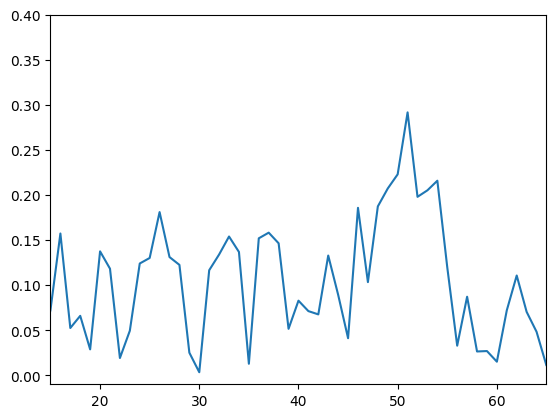

SPXUSD_JPXJPY_reduced_v1; The maximum corr. reaches 0.2916223027587478 at index 51


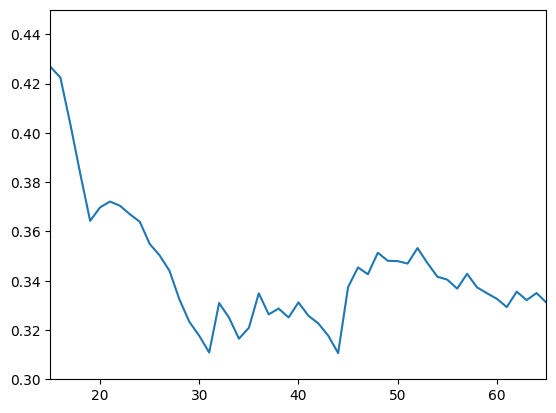

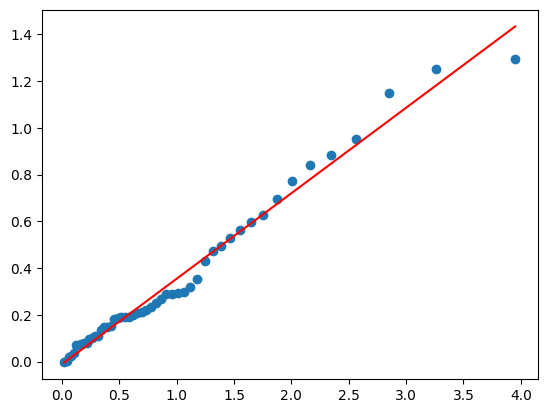

In [ ]:
################################################### Some hyper-parameters

N=X_SPXUSD_JPXJPY_reduced.shape[0]
n=X_SPXUSD_JPXJPY_reduced.shape[1]
d=X_SPXUSD_JPXJPY_reduced.shape[2]
print('Data size', n)

max_threshold_SPXUSD_JPXJPY_reduced = int(np.floor(n/5)) # top 20% if n/5, top10% if n/10
min_threshold = 15
tau=1
kernel = 2 # Gaussian; 1 is for Epan.
J=9
type = 2 # type of Univariate

############################### Correlation and Scatterplot / Choice of threshold \hat k with y_n = Y_{n-\hat k +1,n}
C0_SPXUSD_JPXJPY_reduced = bitcoin_concomittant_corr(X_SPXUSD_JPXJPY_reduced,Y_SPXUSD_JPXJPY_reduced,tau,max_threshold_SPXUSD_JPXJPY_reduced)
plt.plot(C0_SPXUSD_JPXJPY_reduced)
#plt.title('Correlation of SPXUSD_JPXJPY_reduced_v1 in function of k (order stat. index); tau = '+str(tau))
plt.xlim(15,65)  
plt.ylim(-0.01,0.4)  
plt.savefig('Correlation_SPXUSD_JPXJPY_reduced_v1_tau='+str(tau)+'.pdf')
plt.show()

ind=np.argmax(C0_SPXUSD_JPXJPY_reduced[min_threshold:max_threshold_SPXUSD_JPXJPY_reduced])+min_threshold 
print('SPXUSD_JPXJPY_reduced_v1; The maximum corr. reaches ' + str(C0_SPXUSD_JPXJPY_reduced[ind]) + ' at index ' +  str(ind))

############### Hill Plot
G_SPXUSD_JPXJPY_reduced=get_hill_estimator(np.sort(Y_SPXUSD_JPXJPY_reduced[0,:])[::-1])
plt.plot(G_SPXUSD_JPXJPY_reduced)
plt.xlim(15, 65)
#plt.xlim(10, max_threshold_SPXUSD_JPXJPY_reduced)
plt.ylim(0.3,0.45)
#plt.title('SPXUSD_JPXJPY_reduced_v1; Hill plot')
plt.savefig('Hill_Plot_SPXUSD_JPXJPY_reduced_v1.pdf')
plt.show()

####################### Exponential Quantile-Quantile Plot
QQ=Exponential_QQ_Plot_1D(Y_SPXUSD_JPXJPY_reduced,ind)
x=QQ[:,0]
y=QQ[:,1]
res=linregress(QQ[:,0],QQ[:,1])
plt.plot(QQ[:,0], QQ[:,1], 'o')
plt.plot(QQ[:,0], res.intercept + res.slope*QQ[:,0], 'r')
#plt.title('Exponential Quantile-Quantile Plot: SPXUSD_JPXJPY_reduced_v1; k_n is ' + str(ind))
plt.savefig('QQ_SPXUSD_JPXJPY_reduced_v1_k='+str(ind)+'.pdf')
plt.show()

################################################################## FEPLS

Y_sort_index_SPXUSD_JPXJPY_reduced=np.argsort(Y_SPXUSD_JPXJPY_reduced,axis=1)
Y_sort_SPXUSD_JPXJPY_reduced=np.sort(Y_SPXUSD_JPXJPY_reduced,axis=1)
y_n = Y_sort_SPXUSD_JPXJPY_reduced[0,n-ind-1]

y_matrix_SPXUSD_JPXJPY_reduced = y_n*np.ones((N,n)) 

E0_SPXUSD_JPXJPY_reduced=fepls(X_SPXUSD_JPXJPY_reduced,Y_SPXUSD_JPXJPY_reduced,y_matrix_SPXUSD_JPXJPY_reduced,tau)
F0_SPXUSD_JPXJPY_reduced=np.dot(X_SPXUSD_JPXJPY_reduced,E0_SPXUSD_JPXJPY_reduced[0,:])/d # <X_i,dimred>


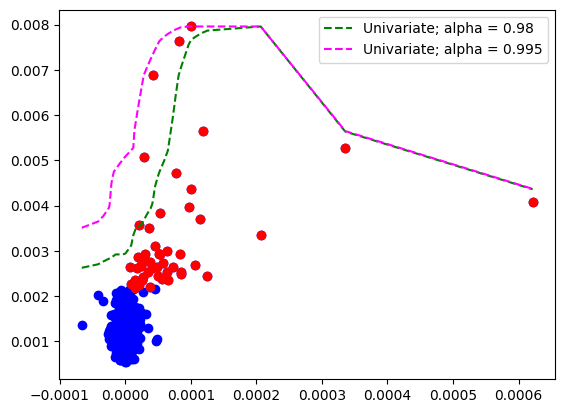

In [ ]:
from scipy.spatial.distance import cdist, pdist, squareform

####################
#dimred of shape (d,) with d=1440; Y|X=<x_i,x_func>*dimred vs Y|<X,dimred>=<x_i,x_func>
# with dimred = x_func = E0_SPXUSD_JPXJPY_reduced[0,:] being the FEPLS.
####################

# But first, we define some functions needed to plot quantiles and tail indexes.

################################################
# Y|X=<x_i,x_func>*dimred vs Y|<X,dimred>=<x_i,x_func>
################################################
@numba.njit(parallel=True, fastmath=False) 
def plot_quantile_conditional_on_sample(X,Y,dimred,x_func,alpha,h_univ_vector,h_func_vector,kernel): 
    n=Y.shape[1]
    out = np.zeros((n,2))
    covalues_here=np.sort(np.dot(X[0,:,:],x_func)/d) # of shape (n,)
    for p in numba.prange(n):
        weight_univ=univariate_Nadaraya_weight_2D(X[0,:,:],dimred,x_func,covalues_here[p],h_univ_vector[p],2,kernel)
        weight_func=functional_Nadaraya_weight_2D(X[0,:,:],covalues_here[p]*dimred,h_func_vector[p],kernel)
        out[p,0]=weighted_quantile(Y[0,:],weight_univ,alpha)
        out[p,1]=weighted_quantile(Y[0,:],weight_func,alpha)
    return out
    
################################################
# Y|X=x_i vs Y|<X,dimred>=<x_i,dimred>
################################################
@numba.njit(parallel=True, fastmath=False) 
def plot_quantile_conditional_on_sample2(X,Y,dimred,alpha,h_univ_vector,h_func_vector,kernel): 
    n=Y.shape[1]
    out = np.zeros((n,2))
    covalues_here=np.dot(X[0,:,:],dimred)/d # of shape (n,)
    for p in numba.prange(n):
        weight_univ=univariate_Nadaraya_weight_2D(X[0,:,:],dimred,x_func,covalues_here[p],h_univ_vector[p],2,kernel)
        weight_func=functional_Nadaraya_weight_2D(X[0,:,:],X[0,p,:],h_func_vector[p],kernel)
        out[p,0]=weighted_quantile(Y[0,:],weight_univ,alpha)
        out[p,1]=weighted_quantile(Y[0,:],weight_func,alpha)
    return out
   
# Y|X=x_i vs Y|<X,dimred>=<x_i,dimred>
@numba.njit(parallel=True, fastmath=False) 
def plot_tail_index_conditional_on_sample_2(X,Y,dimred,x_func,h_univ_vector,h_func_vector,alpha1,J,kernel):
    n=X.shape[1]
    out = np.zeros((n,2))
    covalues_here=np.sort(np.dot(X[0,:,:],dimred)/d) # of shape (n,)
    for p in numba.prange(n):
        weight_univ = univariate_Nadaraya_weight_2D(X[0,:,:],dimred,x_func,covalues_here[p],h_univ_vector[p],2,kernel)
        out[p,0]=tail_index_gamma_estimator_2D(Y,weight_univ,alpha1,J)
        weight_func = functional_Nadaraya_weight_2D(X[0,:,:],X[0,p,:],h_func_vector[p],kernel)
        out[p,1]=tail_index_gamma_estimator_2D(Y,weight_func,alpha1,J)
    return out

#################### Some hyper-parameters for Y|X=<x_i,x_func>*dimred vs Y|<X,dimred>=<x_i,x_func>
### In the case x_func=dimred=E0_SPXUSD_JPXJPY_reduced[0,:] being the FEPLS.

dimred = E0_SPXUSD_JPXJPY_reduced[0,:] # of shape (d,)
x_func = dimred #E0_SPXUSD_JPXJPY_reduced[0,:] #beta_func(d) # of shape (d,)

kernel=2

alpha1=0.98
alpha2=0.995

################################################
h_univ=0.00005
h_func=0.000125
h_univ_vector = h_univ*np.ones(n)
h_func_vector = h_func*np.ones(n)
PP11_sample=plot_quantile_conditional_on_sample(X_SPXUSD_JPXJPY_reduced,Y_SPXUSD_JPXJPY_reduced,dimred,x_func,alpha1,h_univ_vector,h_func_vector,kernel)
PP12_sample=plot_quantile_conditional_on_sample(X_SPXUSD_JPXJPY_reduced,Y_SPXUSD_JPXJPY_reduced,dimred,x_func,alpha2,h_univ_vector,h_func_vector,kernel)
######
plt.scatter(F0_SPXUSD_JPXJPY_reduced[0,:], Y_SPXUSD_JPXJPY_reduced[0,:], color='blue', marker='o')
highest_indices_SPXUSD_JPXJPY_reduced = np.argsort(Y_SPXUSD_JPXJPY_reduced)[0,-ind:]
plt.scatter(F0_SPXUSD_JPXJPY_reduced[0,highest_indices_SPXUSD_JPXJPY_reduced], Y_SPXUSD_JPXJPY_reduced[0,highest_indices_SPXUSD_JPXJPY_reduced], color='red')
#plt.plot(np.sort(F0_SPXUSD_JPXJPY_reduced[0,:]),  PP11_sample[:,1],  label='Functional; alpha = '+str(alpha1))
#plt.plot(np.sort(F0_SPXUSD_JPXJPY_reduced[0,:]),  PP12_sample[:,1],  label='Functional; alpha = '+str(alpha2))
plt.plot(np.sort(F0_SPXUSD_JPXJPY_reduced[0,:]),  PP11_sample[:,0], color = 'green', linestyle='dashed',label='Univariate; alpha = '+str(alpha1))
plt.plot(np.sort(F0_SPXUSD_JPXJPY_reduced[0,:]),  PP12_sample[:,0], color='magenta',  linestyle='dashed',label='Univariate; alpha = '+str(alpha2))
#plt.title('SPXUSD_JPXJPY_reduced_v1; Univariate; h adaptative')
plt.legend()
plt.savefig('Scatterplot_SPXUSD_JPXJPY_reduced_v1_h_func_univ_'+str(h_func)+','+str(h_univ)+'.pdf')
plt.show()


In [ ]:
from scipy.spatial.distance import cdist, pdist, squareform

################################################### Some hyper-parameters
# Y|X=s_l*x_func vs Y|<X,dimred>=s_l*<dimred,x_func> with s_l between min/max(<X_i,x_func>)
###################################################

dimred = E0_SPXUSD_JPXJPY_reduced[0,:] #beta_func6(d)# # of shape (d,)
x_func = beta_func(d) # of shape (d,)
card_func = np.floor(n/5) #np.floor(n*h_func_cv_gg2012)
card_univ = np.floor(n/5)  #np.floor(n*h_univ_cv_gg2012)
kernel=2
alpha1=0.98
alpha2=0.995
alpha3=1-5/n

################################################ Pairwise distance computations

@numba.njit(parallel=True, fastmath=False) 
def pairwise_dist(X,Y): # X,Y vector of length a and b
    a=X.shape[0]
    b=Y.shape[0]
    out = np.zeros((a,b))
    for i in numba.prange(a):
        for j in numba.prange(b):
            out[i,j]=np.abs(X[i]-Y[j])
    return out

@numba.njit(parallel=True, fastmath=False) 
def pairwise_dist_func(X,x_func,L): # L = 1001
    n=X.shape[1]
    d=X.shape[2]
    S_grid = np.linspace(np.min(np.dot(X[0,:,:],x_func)/d),np.max(np.dot(X[0,:,:],x_func)/d),L)
    out = np.zeros((n,L))
    for p in numba.prange(L):
        for i in numba.prange(n):
            out[i,p]=np.linalg.norm(X[0,i,:]-S_grid[p]*x_func)/np.sqrt(d)
    return out

################################################
# Y|X=s_l*x_func vs Y|<X,dimred>=s_l*<dimred,x_func> with s_l between min/max(<X_i,x_func>)
################################################
@numba.njit(parallel=True, fastmath=False) 
def plot_quantile_conditional_on_sample_new(X,Y,dimred,x_func,alpha,h_univ_vector,h_func_vector): 
    n=X.shape[1]
    d=X.shape[2]
    S_grid = np.linspace(np.min(np.dot(X[0,:,:],x_func)/d),np.max(np.dot(X[0,:,:],x_func)/d),1001)
    out = np.zeros((S_grid.shape[0],2))
    for p in numba.prange(S_grid.shape[0]):
        K_h=Gaussian_kernel((np.dot(X[0,:,:],dimred)/d-(np.dot(x_func,dimred)/d)*S_grid[p])/h_func_vector[p])
        weight_univ=K_h/np.sum(K_h)        
        weight_func=functional_Nadaraya_weight_2D(X[0,:,:],S_grid[p]*x_func,h_func_vector[p],2)
        out[p,0]=weighted_quantile(Y[0,:],weight_univ,alpha)
        out[p,1]=weighted_quantile(Y[0,:],weight_func,alpha)
    return out
    
################################################ Tail index

@numba.njit(parallel=True, fastmath=False) 
def tail_index_gamma_estimator_2D(Y,weight,alpha,J):  # Y.shape= (N,n); weight.shape = (n,)
    subdivision=np.array([(1/s) for s in np.arange(1,J+1)] )
    quantile_data2=weighted_quantile(Y[0,:],weight,alpha) # 
    aux=np.zeros((J))
    for j in numba.prange(J):
        quantile_data1=weighted_quantile(Y[0,:],weight,1-subdivision[j]*(1-alpha))
        aux[j] = np.log(quantile_data1)-np.log(quantile_data2)
        aux[j] /= -np.sum(np.log(subdivision))
    return np.sum(aux)

################################################
# Y|X=s_l*x_func vs Y|<X,dimred>=s_l*<dimred,x_func> with s_l between min/max(<X_i,x_func>)
################################################
@numba.njit(parallel=True, fastmath=False) 
def plot_tail_index_conditional_on_sample_new(X,Y,dimred,x_func,h_univ_vector,h_func_vector,alpha1,J,kernel):
    n=X.shape[1]
    S_grid = np.linspace(np.min(np.dot(X[0,:,:],x_func)/d),np.max(np.dot(X[0,:,:],x_func)/d),1001)
    out = np.zeros((S_grid.shape[0],2))    
    covalues_here=np.dot(X_SPXUSD_JPXJPY_reduced[0,:,:],x_func)/d # <x_i,x_func>
    for p in numba.prange(1001):
        K_h=Gaussian_kernel((np.dot(X[0,:,:],dimred)/d-(np.dot(x_func,dimred)/d)*S_grid[p])/h_func_vector[p])
        weight_univ=K_h/np.sum(K_h)        
        weight_func=functional_Nadaraya_weight_2D(X[0,:,:],S_grid[p]*x_func,h_func_vector[p],2)        
        out[p,0]=tail_index_gamma_estimator_2D(Y,weight_univ,alpha1,J)
        out[p,1]=tail_index_gamma_estimator_2D(Y,weight_func,alpha1,J)
    return out

####################################################### Univariate - Choice of h
# Y|X=s_l*x_func vs Y|<X,dimred>=s_l*<dimred,x_func> with s_l between min/max(<X_i,x_func>)
######################################################
#T=np.dot(X_SPXUSD_JPXJPY_reduced[0,:,:],dimred)/d
#T_tilde = np.dot(X_SPXUSD_JPXJPY_reduced[0,:,:],x_func)/d
#H_grid_univ = np.linspace(np.min(T_tilde),np.max(T_tilde),1001)
#Z=(np.dot(dimred,x_func)/d)*H_grid_univ # of shape (1001,)
#D=pairwise_dist(T,Z)
#sorted_univ=np.sort(D,axis=0)
#h_univ_cv_nn_vector=sorted_univ[np.floor(card_univ).astype(np.int64),:]
####################################################### Functional - Choice of h
#sorted_func=np.sort(pairwise_dist_func(X_SPXUSD_JPXJPY_reduced,x_func,1001),axis=0)
#h_func_cv_nn_vector = sorted_func[np.floor(card_func).astype(np.int64),:]
######################################################

################################### Generate an orthonormal function (in the sens of <.,.>_{2,d}) of FEPLS 
# Given vector of length 1440
v = np.copy(E0_SPXUSD_JPXJPY_reduced[0,:]) 

# Generate a random vector of the same length
random_vector = np.random.rand(1440)

# Project the random vector onto the given vector
projection = (np.dot(random_vector, v) / (np.dot(v, v))) * v

# Subtract the projection from the random vector to get an orthogonal vector
orthogonal_vector_to_FEPLS = random_vector - projection

# Normalize the orthogonal vector to ensure it is non-zero and has a standard magnitude
orthogonal_vector_to_FEPLS /= np.linalg.norm(orthogonal_vector_to_FEPLS)/np.sqrt(d)

# Verify orthogonality
#dot_product = np.dot(orthogonal_vector_to_FEPLS, v)/d
#print(f"Dot product (should be close to 0): {dot_product}")
######################################################################


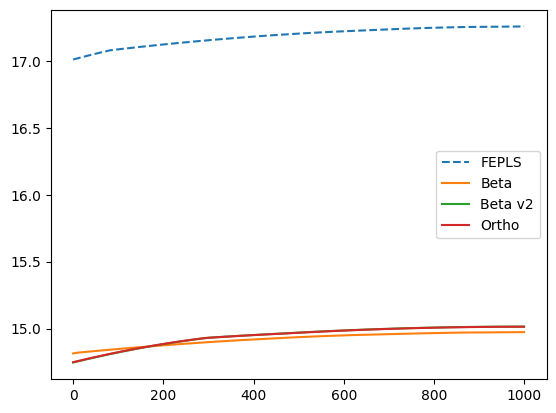

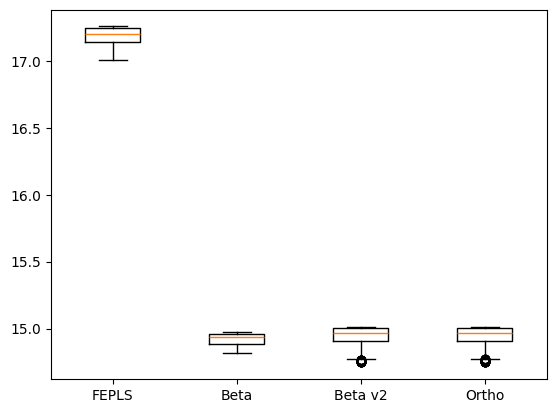

In [ ]:
#################################### Quantiles: Execute & plots
card_univ = np.floor(n/5)
card_func = card_univ

x_func = beta_func(d)
alpha1=0.5 # max 0.98

dimred=E0_SPXUSD_JPXJPY_reduced[0,:]
T=np.dot(X_SPXUSD_JPXJPY_reduced[0,:,:],dimred)/d
T_tilde = np.dot(X_SPXUSD_JPXJPY_reduced[0,:,:],x_func)/d
H_grid_univ = np.linspace(np.min(T_tilde),np.max(T_tilde),1001)
Z=(np.dot(dimred,x_func)/d)*H_grid_univ # of shape (1001,)
D=pairwise_dist(T,Z)
sorted_univ=np.sort(D,axis=0)
h_univ_cv_nn_vector=sorted_univ[np.floor(card_univ).astype(np.int64),:]
sorted_func=np.sort(pairwise_dist_func(X_SPXUSD_JPXJPY_reduced,x_func,1001),axis=0)
h_func_cv_nn_vector = sorted_func[np.floor(card_func).astype(np.int64),:]
quantiles_plot_SPXUSD_JPXJPY_reduced_new0=plot_quantile_conditional_on_sample_new(X_SPXUSD_JPXJPY_reduced,Y_SPXUSD_JPXJPY_reduced,dimred,x_func,alpha1,h_univ_cv_nn_vector,h_func_cv_nn_vector)

dimred=beta_func(d)
T=np.dot(X_SPXUSD_JPXJPY_reduced[0,:,:],dimred)/d
T_tilde = np.dot(X_SPXUSD_JPXJPY_reduced[0,:,:],x_func)/d
H_grid_univ = np.linspace(np.min(T_tilde),np.max(T_tilde),1001)
Z=(np.dot(dimred,x_func)/d)*H_grid_univ # of shape (1001,)
D=pairwise_dist(T,Z)
sorted_univ=np.sort(D,axis=0)
h_univ_cv_nn_vector=sorted_univ[np.floor(card_univ).astype(np.int64),:]
sorted_func=np.sort(pairwise_dist_func(X_SPXUSD_JPXJPY_reduced,x_func,1001),axis=0)
h_func_cv_nn_vector = sorted_func[np.floor(card_func).astype(np.int64),:]
quantiles_plot_SPXUSD_JPXJPY_reduced_new1=plot_quantile_conditional_on_sample_new(X_SPXUSD_JPXJPY_reduced,Y_SPXUSD_JPXJPY_reduced,dimred,x_func,alpha1,h_univ_cv_nn_vector,h_func_cv_nn_vector)

dimred=beta_func3(d)
T=np.dot(X_SPXUSD_JPXJPY_reduced[0,:,:],dimred)/d
T_tilde = np.dot(X_SPXUSD_JPXJPY_reduced[0,:,:],x_func)/d
H_grid_univ = np.linspace(np.min(T_tilde),np.max(T_tilde),1001)
Z=(np.dot(dimred,x_func)/d)*H_grid_univ # of shape (1001,)
D=pairwise_dist(T,Z)
sorted_univ=np.sort(D,axis=0)
h_univ_cv_nn_vector=sorted_univ[np.floor(card_univ).astype(np.int64),:]
sorted_func=np.sort(pairwise_dist_func(X_SPXUSD_JPXJPY_reduced,x_func,1001),axis=0)
h_func_cv_nn_vector = sorted_func[np.floor(card_func).astype(np.int64),:]
quantiles_plot_SPXUSD_JPXJPY_reduced_new3=plot_quantile_conditional_on_sample_new(X_SPXUSD_JPXJPY_reduced,Y_SPXUSD_JPXJPY_reduced,dimred,x_func,alpha1,h_univ_cv_nn_vector,h_func_cv_nn_vector)

dimred=orthogonal_vector_to_FEPLS
T=np.dot(X_SPXUSD_JPXJPY_reduced[0,:,:],dimred)/d
T_tilde = np.dot(X_SPXUSD_JPXJPY_reduced[0,:,:],x_func)/d
H_grid_univ = np.linspace(np.min(T_tilde),np.max(T_tilde),1001)
Z=(np.dot(dimred,x_func)/d)*H_grid_univ # of shape (1001,)
D=pairwise_dist(T,Z)
sorted_univ=np.sort(D,axis=0)
h_univ_cv_nn_vector=sorted_univ[np.floor(card_univ).astype(np.int64),:]
sorted_func=np.sort(pairwise_dist_func(X_SPXUSD_JPXJPY_reduced,x_func,1001),axis=0)
h_func_cv_nn_vector = sorted_func[np.floor(card_func).astype(np.int64),:]
quantiles_plot_SPXUSD_JPXJPY_reduced_new8=plot_quantile_conditional_on_sample_new(X_SPXUSD_JPXJPY_reduced,Y_SPXUSD_JPXJPY_reduced,dimred,x_func,alpha1,h_univ_cv_nn_vector,h_func_cv_nn_vector)

R1=relative_gap_quantiles_SPXUSD_JPXJPY_reduced_new0 = np.abs(quantiles_plot_SPXUSD_JPXJPY_reduced_new0[:,0] - quantiles_plot_SPXUSD_JPXJPY_reduced_new0[:,1]) / (np.abs(quantiles_plot_SPXUSD_JPXJPY_reduced_new0[:,0]) + 1e-20)
R2=relative_gap_quantiles_SPXUSD_JPXJPY_reduced_new1 = np.abs(quantiles_plot_SPXUSD_JPXJPY_reduced_new1[:,0] - quantiles_plot_SPXUSD_JPXJPY_reduced_new1[:,1]) / (np.abs(quantiles_plot_SPXUSD_JPXJPY_reduced_new1[:,0]) + 1e-20)
#relative_gap_quantiles_SPXUSD_JPXJPY_reduced_new2 = np.abs(quantiles_plot_SPXUSD_JPXJPY_reduced_new2[:,0] - quantiles_plot_SPXUSD_JPXJPY_reduced_new2[:,1]) / (np.abs(quantiles_plot_SPXUSD_JPXJPY_reduced_new2[:,0]) + 1e-20)
R3=relative_gap_quantiles_SPXUSD_JPXJPY_reduced_new3 = np.abs(quantiles_plot_SPXUSD_JPXJPY_reduced_new3[:,0] - quantiles_plot_SPXUSD_JPXJPY_reduced_new3[:,1]) / (np.abs(quantiles_plot_SPXUSD_JPXJPY_reduced_new3[:,0]) + 1e-20)
#relative_gap_quantiles_SPXUSD_JPXJPY_reduced_new4 = np.abs(quantiles_plot_SPXUSD_JPXJPY_reduced_new4[:,0] - quantiles_plot_SPXUSD_JPXJPY_reduced_new4[:,1]) / (np.abs(quantiles_plot_SPXUSD_JPXJPY_reduced_new4[:,0]) + 1e-20)
#relative_gap_quantiles_SPXUSD_JPXJPY_reduced_new5 = np.abs(quantiles_plot_SPXUSD_JPXJPY_reduced_new5[:,0] - quantiles_plot_SPXUSD_JPXJPY_reduced_new5[:,1]) / (np.abs(quantiles_plot_SPXUSD_JPXJPY_reduced_new5[:,0]) + 1e-20)
#relative_gap_quantiles_SPXUSD_JPXJPY_reduced_new6 = np.abs(quantiles_plot_SPXUSD_JPXJPY_reduced_new6[:,0] - quantiles_plot_SPXUSD_JPXJPY_reduced_new6[:,1]) / (np.abs(quantiles_plot_SPXUSD_JPXJPY_reduced_new6[:,0]) + 1e-20)
#relative_gap_quantiles_SPXUSD_JPXJPY_reduced_new7 = np.abs(quantiles_plot_SPXUSD_JPXJPY_reduced_new7[:,0] - quantiles_plot_SPXUSD_JPXJPY_reduced_new7[:,1]) / (np.abs(quantiles_plot_SPXUSD_JPXJPY_reduced_new7[:,0]) + 1e-20)
R4=relative_gap_quantiles_SPXUSD_JPXJPY_reduced_new8 = np.abs(quantiles_plot_SPXUSD_JPXJPY_reduced_new8[:,0] - quantiles_plot_SPXUSD_JPXJPY_reduced_new8[:,1]) / (np.abs(quantiles_plot_SPXUSD_JPXJPY_reduced_new8[:,0]) + 1e-20)

plt.plot(np.sort(R1)*100,label='FEPLS', linestyle='dashed')
plt.plot(np.sort(R2)*100,label='Beta')
#plt.plot(np.sort(relative_gap_quantiles_SPXUSD_JPXJPY_reduced_new2)*100,label='beta_func2/beta_func')
plt.plot(np.sort(R3)*100,label='Beta v2')
#plt.plot(np.sort(relative_gap_quantiles_SPXUSD_JPXJPY_reduced_new4)*100,label='beta_func4/beta_func')
#plt.plot(np.sort(relative_gap_quantiles_SPXUSD_JPXJPY_reduced_new5)*100,label='beta_func5/beta_func')
#plt.plot(np.sort(relative_gap_quantiles_SPXUSD_JPXJPY_reduced_new6)*100,label='beta_func6/beta_func')
#plt.plot(np.sort(relative_gap_quantiles_SPXUSD_JPXJPY_reduced_new7)*100,label='beta_func7/beta_func')
plt.plot(np.sort(R4)*100,label='Ortho')

plt.legend()
#plt.title('Relative_gap_Tail_index_SPXUSDJPXJPY_reduced_v1; alpha = '+str(alpha1)+'; h adaptative ')
plt.savefig('Quantiles_SPXUSD_JPXJPY_reduced_v1_beta_func_alpha='+str(alpha1)+'_card_'+str(card_func.astype(np.int64))+'_h_adapt.pdf')
plt.show()

R_list = [100*R1, 100*R2, 100*R3, 100*R4]
plt.boxplot(R_list)
plt.xticks([1, 2, 3, 4], ['FEPLS', 'Beta', 'Beta v2', 'Ortho'])
plt.savefig('Quantiles_boxplot_SPXUSD_JPXJPY_reduced_v1_beta_func_alpha='+str(alpha1)+'_card_'+str(card_func.astype(np.int64))+'_h_adapt_tau='+str(tau)+'.pdf).pdf')
plt.show()


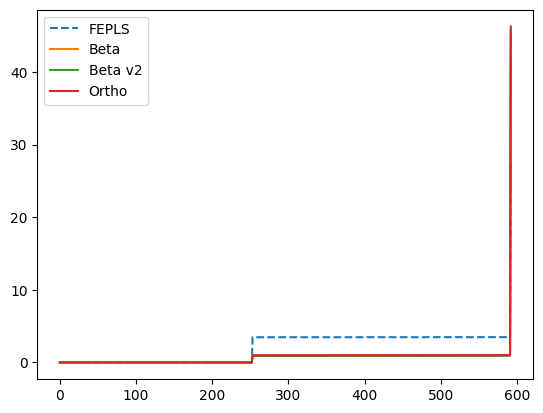

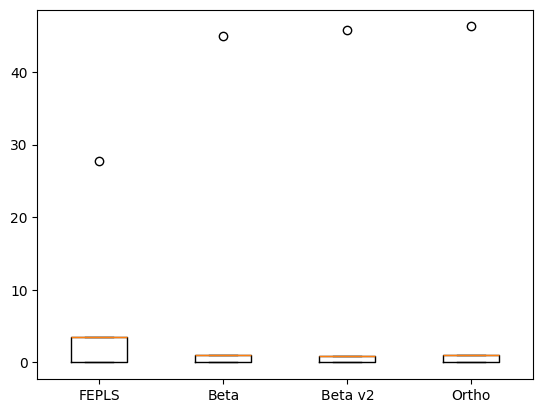

In [ ]:
#################################### Tail index : Execute & plots

card_univ = np.floor(n/5)
card_func = card_univ

x_func = beta_func(d)
alpha3=0.8


dimred=E0_SPXUSD_JPXJPY_reduced[0,:]
T=np.dot(X_SPXUSD_JPXJPY_reduced[0,:,:],dimred)/d
T_tilde = np.dot(X_SPXUSD_JPXJPY_reduced[0,:,:],x_func)/d
H_grid_univ = np.linspace(np.min(T_tilde),np.max(T_tilde),1001)
Z=(np.dot(dimred,x_func)/d)*H_grid_univ # of shape (1001,)
D=pairwise_dist(T,Z)
sorted_univ=np.sort(D,axis=0)
h_univ_cv_nn_vector=sorted_univ[np.floor(card_univ).astype(np.int64),:]
sorted_func=np.sort(pairwise_dist_func(X_SPXUSD_JPXJPY_reduced,x_func,1001),axis=0)
h_func_cv_nn_vector = sorted_func[np.floor(card_func).astype(np.int64),:]
gamma_plot_SPXUSD_JPXJPY_reduced_new0=plot_tail_index_conditional_on_sample_new(X_SPXUSD_JPXJPY_reduced,Y_SPXUSD_JPXJPY_reduced,dimred,x_func,h_univ_vector,h_func_vector,alpha3,J,kernel)

dimred=beta_func(d)
T=np.dot(X_SPXUSD_JPXJPY_reduced[0,:,:],dimred)/d
T_tilde = np.dot(X_SPXUSD_JPXJPY_reduced[0,:,:],x_func)/d
H_grid_univ = np.linspace(np.min(T_tilde),np.max(T_tilde),1001)
Z=(np.dot(dimred,x_func)/d)*H_grid_univ # of shape (1001,)
D=pairwise_dist(T,Z)
sorted_univ=np.sort(D,axis=0)
h_univ_cv_nn_vector=sorted_univ[np.floor(card_univ).astype(np.int64),:]
sorted_func=np.sort(pairwise_dist_func(X_SPXUSD_JPXJPY_reduced,x_func,1001),axis=0)
h_func_cv_nn_vector = sorted_func[np.floor(card_func).astype(np.int64),:]
gamma_plot_SPXUSD_JPXJPY_reduced_new1=plot_tail_index_conditional_on_sample_new(X_SPXUSD_JPXJPY_reduced,Y_SPXUSD_JPXJPY_reduced,dimred,x_func,h_univ_vector,h_func_vector,alpha3,J,kernel)

dimred=beta_func3(d)
T=np.dot(X_SPXUSD_JPXJPY_reduced[0,:,:],dimred)/d
T_tilde = np.dot(X_SPXUSD_JPXJPY_reduced[0,:,:],x_func)/d
H_grid_univ = np.linspace(np.min(T_tilde),np.max(T_tilde),1001)
Z=(np.dot(dimred,x_func)/d)*H_grid_univ # of shape (1001,)
D=pairwise_dist(T,Z)
sorted_univ=np.sort(D,axis=0)
h_univ_cv_nn_vector=sorted_univ[np.floor(card_univ).astype(np.int64),:]
sorted_func=np.sort(pairwise_dist_func(X_SPXUSD_JPXJPY_reduced,x_func,1001),axis=0)
h_func_cv_nn_vector = sorted_func[np.floor(card_func).astype(np.int64),:]
gamma_plot_SPXUSD_JPXJPY_reduced_new3=plot_tail_index_conditional_on_sample_new(X_SPXUSD_JPXJPY_reduced,Y_SPXUSD_JPXJPY_reduced,dimred,x_func,h_univ_vector,h_func_vector,alpha3,J,kernel)

dimred=orthogonal_vector_to_FEPLS
T=np.dot(X_SPXUSD_JPXJPY_reduced[0,:,:],dimred)/d
T_tilde = np.dot(X_SPXUSD_JPXJPY_reduced[0,:,:],x_func)/d
H_grid_univ = np.linspace(np.min(T_tilde),np.max(T_tilde),1001)
Z=(np.dot(dimred,x_func)/d)*H_grid_univ # of shape (1001,)
D=pairwise_dist(T,Z)
sorted_univ=np.sort(D,axis=0)
h_univ_cv_nn_vector=sorted_univ[np.floor(card_univ).astype(np.int64),:]
sorted_func=np.sort(pairwise_dist_func(X_SPXUSD_JPXJPY_reduced,x_func,1001),axis=0)
h_func_cv_nn_vector = sorted_func[np.floor(card_func).astype(np.int64),:]
gamma_plot_SPXUSD_JPXJPY_reduced_new8=plot_tail_index_conditional_on_sample_new(X_SPXUSD_JPXJPY_reduced,Y_SPXUSD_JPXJPY_reduced,dimred,x_func,h_univ_vector,h_func_vector,alpha3,J,kernel)

T1=relative_gap_tail_index_SPXUSD_JPXJPY_reduced_new0 = np.abs(gamma_plot_SPXUSD_JPXJPY_reduced_new0[:,0] - gamma_plot_SPXUSD_JPXJPY_reduced_new0[:,1]) / (np.abs(gamma_plot_SPXUSD_JPXJPY_reduced_new0[:,0]) + 1e-10)
T2=relative_gap_tail_index_SPXUSD_JPXJPY_reduced_new1 = np.abs(gamma_plot_SPXUSD_JPXJPY_reduced_new1[:,0] - gamma_plot_SPXUSD_JPXJPY_reduced_new1[:,1]) / (np.abs(gamma_plot_SPXUSD_JPXJPY_reduced_new1[:,0]) + 1e-10)
T3=relative_gap_tail_index_SPXUSD_JPXJPY_reduced_new3 = np.abs(gamma_plot_SPXUSD_JPXJPY_reduced_new3[:,0] - gamma_plot_SPXUSD_JPXJPY_reduced_new3[:,1]) / (np.abs(gamma_plot_SPXUSD_JPXJPY_reduced_new3[:,0]) + 1e-10)
T4=relative_gap_tail_index_SPXUSD_JPXJPY_reduced_new8 = np.abs(gamma_plot_SPXUSD_JPXJPY_reduced_new8[:,0] - gamma_plot_SPXUSD_JPXJPY_reduced_new8[:,1]) / (np.abs(gamma_plot_SPXUSD_JPXJPY_reduced_new8[:,0]) + 1e-10)

plt.plot(np.sort(relative_gap_tail_index_SPXUSD_JPXJPY_reduced_new0)*100,label='FEPLS', linestyle='dashed')
plt.plot(np.sort(relative_gap_tail_index_SPXUSD_JPXJPY_reduced_new1)*100,label='Beta')
plt.plot(np.sort(relative_gap_tail_index_SPXUSD_JPXJPY_reduced_new3)*100,label='Beta v2')
plt.plot(np.sort(relative_gap_tail_index_SPXUSD_JPXJPY_reduced_new8)*100,label='Ortho')

plt.legend()
#plt.ylim(0,200)
#plt.title('Relative_gap_Tail_index_SPXUSDJPXJPY_reduced_v1; alpha = '+str(alpha3)+'; h adaptative ')
plt.savefig('Tail_index_SPXUSD_JPXJPY_reduced_v1_beta_func_alpha='+str(alpha3)+'_card_'+str(card_func.astype(np.int64))+'.pdf')
plt.show()

filtered_T1 = T1[~np.isnan(T1)]
filtered_T2 = T2[~np.isnan(T2)]
filtered_T3 = T3[~np.isnan(T3)]
filtered_T4 = T4[~np.isnan(T4)]
T_filtered_list = [100*filtered_T1, 100*filtered_T2, 100*filtered_T3, 100*filtered_T4]
plt.boxplot(T_filtered_list)
plt.xticks([1, 2, 3, 4], ['FEPLS', 'Beta', 'Beta v2', 'Ortho'])
plt.savefig('Tail_index_boxplot_SPXUSD_JPXJPY_reduced_v1_beta_func_alpha='+str(alpha3)+'_card_'+str(card_func.astype(np.int64))+'_tau='+str(tau)+'.pdf')
plt.show()

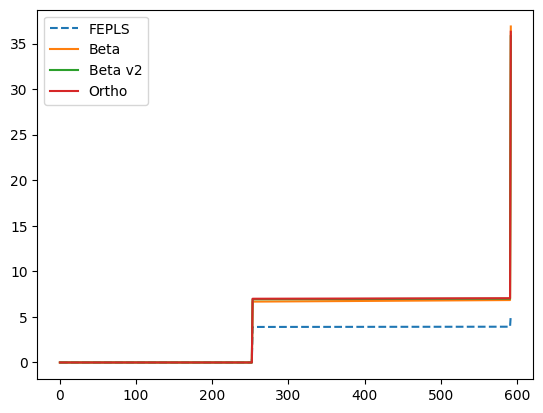

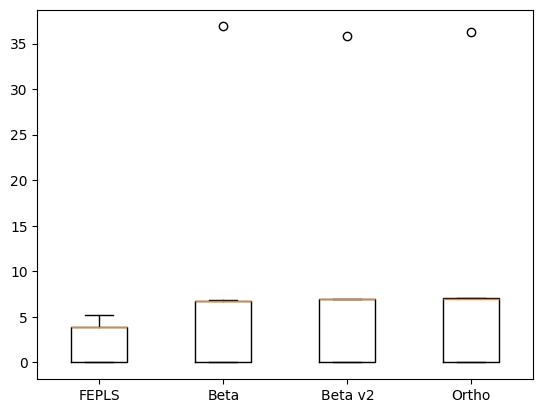

In [ ]:
#################################### Tail index : Execute & plots

card_univ = np.floor(n/5)
card_func = card_univ

x_func = beta_func(d)
alpha3=0.9


dimred=E0_SPXUSD_JPXJPY_reduced[0,:]
T=np.dot(X_SPXUSD_JPXJPY_reduced[0,:,:],dimred)/d
T_tilde = np.dot(X_SPXUSD_JPXJPY_reduced[0,:,:],x_func)/d
H_grid_univ = np.linspace(np.min(T_tilde),np.max(T_tilde),1001)
Z=(np.dot(dimred,x_func)/d)*H_grid_univ # of shape (1001,)
D=pairwise_dist(T,Z)
sorted_univ=np.sort(D,axis=0)
h_univ_cv_nn_vector=sorted_univ[np.floor(card_univ).astype(np.int64),:]
sorted_func=np.sort(pairwise_dist_func(X_SPXUSD_JPXJPY_reduced,x_func,1001),axis=0)
h_func_cv_nn_vector = sorted_func[np.floor(card_func).astype(np.int64),:]
gamma_plot_SPXUSD_JPXJPY_reduced_new0=plot_tail_index_conditional_on_sample_new(X_SPXUSD_JPXJPY_reduced,Y_SPXUSD_JPXJPY_reduced,dimred,x_func,h_univ_vector,h_func_vector,alpha3,J,kernel)

dimred=beta_func(d)
T=np.dot(X_SPXUSD_JPXJPY_reduced[0,:,:],dimred)/d
T_tilde = np.dot(X_SPXUSD_JPXJPY_reduced[0,:,:],x_func)/d
H_grid_univ = np.linspace(np.min(T_tilde),np.max(T_tilde),1001)
Z=(np.dot(dimred,x_func)/d)*H_grid_univ # of shape (1001,)
D=pairwise_dist(T,Z)
sorted_univ=np.sort(D,axis=0)
h_univ_cv_nn_vector=sorted_univ[np.floor(card_univ).astype(np.int64),:]
sorted_func=np.sort(pairwise_dist_func(X_SPXUSD_JPXJPY_reduced,x_func,1001),axis=0)
h_func_cv_nn_vector = sorted_func[np.floor(card_func).astype(np.int64),:]
gamma_plot_SPXUSD_JPXJPY_reduced_new1=plot_tail_index_conditional_on_sample_new(X_SPXUSD_JPXJPY_reduced,Y_SPXUSD_JPXJPY_reduced,dimred,x_func,h_univ_vector,h_func_vector,alpha3,J,kernel)

dimred=beta_func3(d)
T=np.dot(X_SPXUSD_JPXJPY_reduced[0,:,:],dimred)/d
T_tilde = np.dot(X_SPXUSD_JPXJPY_reduced[0,:,:],x_func)/d
H_grid_univ = np.linspace(np.min(T_tilde),np.max(T_tilde),1001)
Z=(np.dot(dimred,x_func)/d)*H_grid_univ # of shape (1001,)
D=pairwise_dist(T,Z)
sorted_univ=np.sort(D,axis=0)
h_univ_cv_nn_vector=sorted_univ[np.floor(card_univ).astype(np.int64),:]
sorted_func=np.sort(pairwise_dist_func(X_SPXUSD_JPXJPY_reduced,x_func,1001),axis=0)
h_func_cv_nn_vector = sorted_func[np.floor(card_func).astype(np.int64),:]
gamma_plot_SPXUSD_JPXJPY_reduced_new3=plot_tail_index_conditional_on_sample_new(X_SPXUSD_JPXJPY_reduced,Y_SPXUSD_JPXJPY_reduced,dimred,x_func,h_univ_vector,h_func_vector,alpha3,J,kernel)

dimred=orthogonal_vector_to_FEPLS
T=np.dot(X_SPXUSD_JPXJPY_reduced[0,:,:],dimred)/d
T_tilde = np.dot(X_SPXUSD_JPXJPY_reduced[0,:,:],x_func)/d
H_grid_univ = np.linspace(np.min(T_tilde),np.max(T_tilde),1001)
Z=(np.dot(dimred,x_func)/d)*H_grid_univ # of shape (1001,)
D=pairwise_dist(T,Z)
sorted_univ=np.sort(D,axis=0)
h_univ_cv_nn_vector=sorted_univ[np.floor(card_univ).astype(np.int64),:]
sorted_func=np.sort(pairwise_dist_func(X_SPXUSD_JPXJPY_reduced,x_func,1001),axis=0)
h_func_cv_nn_vector = sorted_func[np.floor(card_func).astype(np.int64),:]
gamma_plot_SPXUSD_JPXJPY_reduced_new8=plot_tail_index_conditional_on_sample_new(X_SPXUSD_JPXJPY_reduced,Y_SPXUSD_JPXJPY_reduced,dimred,x_func,h_univ_vector,h_func_vector,alpha3,J,kernel)

T1=relative_gap_tail_index_SPXUSD_JPXJPY_reduced_new0 = np.abs(gamma_plot_SPXUSD_JPXJPY_reduced_new0[:,0] - gamma_plot_SPXUSD_JPXJPY_reduced_new0[:,1]) / (np.abs(gamma_plot_SPXUSD_JPXJPY_reduced_new0[:,0]) + 1e-10)
T2=relative_gap_tail_index_SPXUSD_JPXJPY_reduced_new1 = np.abs(gamma_plot_SPXUSD_JPXJPY_reduced_new1[:,0] - gamma_plot_SPXUSD_JPXJPY_reduced_new1[:,1]) / (np.abs(gamma_plot_SPXUSD_JPXJPY_reduced_new1[:,0]) + 1e-10)
T3=relative_gap_tail_index_SPXUSD_JPXJPY_reduced_new3 = np.abs(gamma_plot_SPXUSD_JPXJPY_reduced_new3[:,0] - gamma_plot_SPXUSD_JPXJPY_reduced_new3[:,1]) / (np.abs(gamma_plot_SPXUSD_JPXJPY_reduced_new3[:,0]) + 1e-10)
T4=relative_gap_tail_index_SPXUSD_JPXJPY_reduced_new8 = np.abs(gamma_plot_SPXUSD_JPXJPY_reduced_new8[:,0] - gamma_plot_SPXUSD_JPXJPY_reduced_new8[:,1]) / (np.abs(gamma_plot_SPXUSD_JPXJPY_reduced_new8[:,0]) + 1e-10)

plt.plot(np.sort(relative_gap_tail_index_SPXUSD_JPXJPY_reduced_new0)*100,label='FEPLS', linestyle='dashed')
plt.plot(np.sort(relative_gap_tail_index_SPXUSD_JPXJPY_reduced_new1)*100,label='Beta')
plt.plot(np.sort(relative_gap_tail_index_SPXUSD_JPXJPY_reduced_new3)*100,label='Beta v2')
plt.plot(np.sort(relative_gap_tail_index_SPXUSD_JPXJPY_reduced_new8)*100,label='Ortho')

plt.legend()
#plt.ylim(0,200)
#plt.title('Relative_gap_Tail_index_SPXUSDJPXJPY_reduced_v1; alpha = '+str(alpha3)+'; h adaptative ')
plt.savefig('Tail_index_SPXUSD_JPXJPY_reduced_v1_beta_func_alpha='+str(alpha3)+'_card_'+str(card_func.astype(np.int64))+'.pdf')
plt.show()

filtered_T1 = T1[~np.isnan(T1)]
filtered_T2 = T2[~np.isnan(T2)]
filtered_T3 = T3[~np.isnan(T3)]
filtered_T4 = T4[~np.isnan(T4)]
T_filtered_list = [100*filtered_T1, 100*filtered_T2, 100*filtered_T3, 100*filtered_T4]
plt.boxplot(T_filtered_list)
plt.xticks([1, 2, 3, 4], ['FEPLS', 'Beta', 'Beta v2', 'Ortho'])
plt.savefig('Tail_index_boxplot_SPXUSD_JPXJPY_reduced_v1_beta_func_alpha='+str(alpha3)+'_card_'+str(card_func.astype(np.int64))+'_tau='+str(tau)+'.pdf')
plt.show()

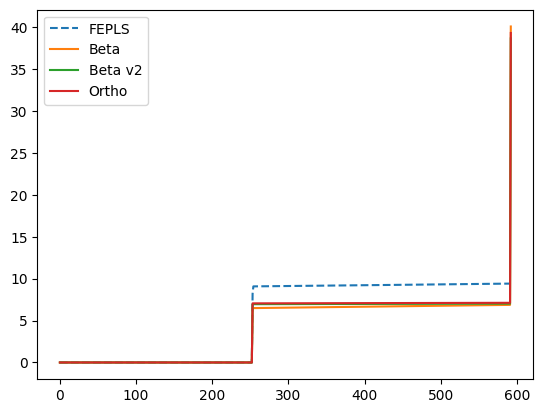

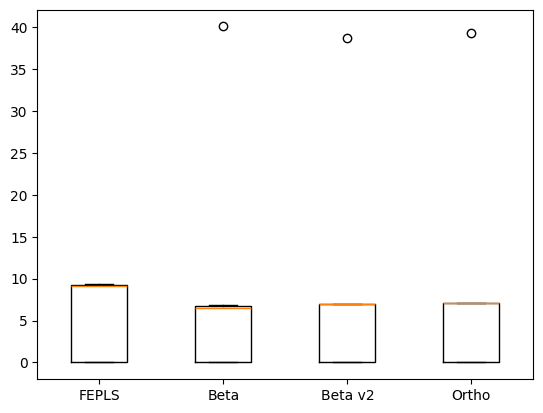

In [ ]:
#################################### Tail index : Execute & plots

card_univ = np.floor(n/5)
card_func = card_univ

x_func = beta_func(d)
alpha3=0.95


dimred=E0_SPXUSD_JPXJPY_reduced[0,:]
T=np.dot(X_SPXUSD_JPXJPY_reduced[0,:,:],dimred)/d
T_tilde = np.dot(X_SPXUSD_JPXJPY_reduced[0,:,:],x_func)/d
H_grid_univ = np.linspace(np.min(T_tilde),np.max(T_tilde),1001)
Z=(np.dot(dimred,x_func)/d)*H_grid_univ # of shape (1001,)
D=pairwise_dist(T,Z)
sorted_univ=np.sort(D,axis=0)
h_univ_cv_nn_vector=sorted_univ[np.floor(card_univ).astype(np.int64),:]
sorted_func=np.sort(pairwise_dist_func(X_SPXUSD_JPXJPY_reduced,x_func,1001),axis=0)
h_func_cv_nn_vector = sorted_func[np.floor(card_func).astype(np.int64),:]
gamma_plot_SPXUSD_JPXJPY_reduced_new0=plot_tail_index_conditional_on_sample_new(X_SPXUSD_JPXJPY_reduced,Y_SPXUSD_JPXJPY_reduced,dimred,x_func,h_univ_vector,h_func_vector,alpha3,J,kernel)

dimred=beta_func(d)
T=np.dot(X_SPXUSD_JPXJPY_reduced[0,:,:],dimred)/d
T_tilde = np.dot(X_SPXUSD_JPXJPY_reduced[0,:,:],x_func)/d
H_grid_univ = np.linspace(np.min(T_tilde),np.max(T_tilde),1001)
Z=(np.dot(dimred,x_func)/d)*H_grid_univ # of shape (1001,)
D=pairwise_dist(T,Z)
sorted_univ=np.sort(D,axis=0)
h_univ_cv_nn_vector=sorted_univ[np.floor(card_univ).astype(np.int64),:]
sorted_func=np.sort(pairwise_dist_func(X_SPXUSD_JPXJPY_reduced,x_func,1001),axis=0)
h_func_cv_nn_vector = sorted_func[np.floor(card_func).astype(np.int64),:]
gamma_plot_SPXUSD_JPXJPY_reduced_new1=plot_tail_index_conditional_on_sample_new(X_SPXUSD_JPXJPY_reduced,Y_SPXUSD_JPXJPY_reduced,dimred,x_func,h_univ_vector,h_func_vector,alpha3,J,kernel)

dimred=beta_func3(d)
T=np.dot(X_SPXUSD_JPXJPY_reduced[0,:,:],dimred)/d
T_tilde = np.dot(X_SPXUSD_JPXJPY_reduced[0,:,:],x_func)/d
H_grid_univ = np.linspace(np.min(T_tilde),np.max(T_tilde),1001)
Z=(np.dot(dimred,x_func)/d)*H_grid_univ # of shape (1001,)
D=pairwise_dist(T,Z)
sorted_univ=np.sort(D,axis=0)
h_univ_cv_nn_vector=sorted_univ[np.floor(card_univ).astype(np.int64),:]
sorted_func=np.sort(pairwise_dist_func(X_SPXUSD_JPXJPY_reduced,x_func,1001),axis=0)
h_func_cv_nn_vector = sorted_func[np.floor(card_func).astype(np.int64),:]
gamma_plot_SPXUSD_JPXJPY_reduced_new3=plot_tail_index_conditional_on_sample_new(X_SPXUSD_JPXJPY_reduced,Y_SPXUSD_JPXJPY_reduced,dimred,x_func,h_univ_vector,h_func_vector,alpha3,J,kernel)

dimred=orthogonal_vector_to_FEPLS
T=np.dot(X_SPXUSD_JPXJPY_reduced[0,:,:],dimred)/d
T_tilde = np.dot(X_SPXUSD_JPXJPY_reduced[0,:,:],x_func)/d
H_grid_univ = np.linspace(np.min(T_tilde),np.max(T_tilde),1001)
Z=(np.dot(dimred,x_func)/d)*H_grid_univ # of shape (1001,)
D=pairwise_dist(T,Z)
sorted_univ=np.sort(D,axis=0)
h_univ_cv_nn_vector=sorted_univ[np.floor(card_univ).astype(np.int64),:]
sorted_func=np.sort(pairwise_dist_func(X_SPXUSD_JPXJPY_reduced,x_func,1001),axis=0)
h_func_cv_nn_vector = sorted_func[np.floor(card_func).astype(np.int64),:]
gamma_plot_SPXUSD_JPXJPY_reduced_new8=plot_tail_index_conditional_on_sample_new(X_SPXUSD_JPXJPY_reduced,Y_SPXUSD_JPXJPY_reduced,dimred,x_func,h_univ_vector,h_func_vector,alpha3,J,kernel)

T1=relative_gap_tail_index_SPXUSD_JPXJPY_reduced_new0 = np.abs(gamma_plot_SPXUSD_JPXJPY_reduced_new0[:,0] - gamma_plot_SPXUSD_JPXJPY_reduced_new0[:,1]) / (np.abs(gamma_plot_SPXUSD_JPXJPY_reduced_new0[:,0]) + 1e-10)
T2=relative_gap_tail_index_SPXUSD_JPXJPY_reduced_new1 = np.abs(gamma_plot_SPXUSD_JPXJPY_reduced_new1[:,0] - gamma_plot_SPXUSD_JPXJPY_reduced_new1[:,1]) / (np.abs(gamma_plot_SPXUSD_JPXJPY_reduced_new1[:,0]) + 1e-10)
T3=relative_gap_tail_index_SPXUSD_JPXJPY_reduced_new3 = np.abs(gamma_plot_SPXUSD_JPXJPY_reduced_new3[:,0] - gamma_plot_SPXUSD_JPXJPY_reduced_new3[:,1]) / (np.abs(gamma_plot_SPXUSD_JPXJPY_reduced_new3[:,0]) + 1e-10)
T4=relative_gap_tail_index_SPXUSD_JPXJPY_reduced_new8 = np.abs(gamma_plot_SPXUSD_JPXJPY_reduced_new8[:,0] - gamma_plot_SPXUSD_JPXJPY_reduced_new8[:,1]) / (np.abs(gamma_plot_SPXUSD_JPXJPY_reduced_new8[:,0]) + 1e-10)

plt.plot(np.sort(relative_gap_tail_index_SPXUSD_JPXJPY_reduced_new0)*100,label='FEPLS', linestyle='dashed')
plt.plot(np.sort(relative_gap_tail_index_SPXUSD_JPXJPY_reduced_new1)*100,label='Beta')
plt.plot(np.sort(relative_gap_tail_index_SPXUSD_JPXJPY_reduced_new3)*100,label='Beta v2')
plt.plot(np.sort(relative_gap_tail_index_SPXUSD_JPXJPY_reduced_new8)*100,label='Ortho')

plt.legend()
#plt.ylim(0,200)
#plt.title('Relative_gap_Tail_index_SPXUSDJPXJPY_reduced_v1; alpha = '+str(alpha3)+'; h adaptative ')
plt.savefig('Tail_index_SPXUSD_JPXJPY_reduced_v1_beta_func_alpha='+str(alpha3)+'_card_'+str(card_func.astype(np.int64))+'.pdf')
plt.show()

filtered_T1 = T1[~np.isnan(T1)]
filtered_T2 = T2[~np.isnan(T2)]
filtered_T3 = T3[~np.isnan(T3)]
filtered_T4 = T4[~np.isnan(T4)]
T_filtered_list = [100*filtered_T1, 100*filtered_T2, 100*filtered_T3, 100*filtered_T4]
plt.boxplot(T_filtered_list)
plt.xticks([1, 2, 3, 4], ['FEPLS', 'Beta', 'Beta v2', 'Ortho'])
plt.savefig('Tail_index_boxplot_SPXUSD_JPXJPY_reduced_v1_beta_func_alpha='+str(alpha3)+'_card_'+str(card_func.astype(np.int64))+'_tau='+str(tau)+'.pdf')
plt.show()